In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
from mpl_toolkits.axes_grid1 import make_axes_locatable

from qick import *
from qick.helpers import gauss
from tqdm import tqdm_notebook as tqdm

import time
import os
expt_path=os.getcwd()+'/data'
import sys
import scipy as sp
import json

import qutip as qt
import qutip.visualization as qplt

from slab.instruments import *
from slab.experiment import Experiment
from slab.datamanagement import SlabFile
from slab import get_next_filename, AttrDict

# Figure params
plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams.update({'font.size': 16})
style.use('default')

np.set_printoptions(threshold=sys.maxsize)

Could not import QickInstrument (will only work if running on rfsoc). If running on rfsoc, try install/update qick package
Warning failed to import AWG81180A
Warning failed to import Tek5014
Warning failed to import Tek70001
Warning failed to import M8195A


C:\ProgramData\Anaconda3\lib\site-packages\IPython\qt.py:12: ShimWarning: The `IPython.qt` package has been deprecated since IPython 4.0. You should import from qtconsole instead.
  warn("The `IPython.qt` package has been deprecated since IPython 4.0. "


Could not load InstrumentManagerWindow
Could not load labbrick
Could not load Autonics TM4 Driver
Could not load Oxford Trition driver


In [2]:
sys.path.append(os.getcwd()+'/../../qutip_sims')
from QSwitch import QSwitch
from PulseSequence import PulseSequence

# Getting ideal rho

In [3]:
# 2 cardinal points on Bloch sphere for each measurement axis
psiZ = [qt.basis(2,0), qt.basis(2,1)]
psiX = [1/np.sqrt(2)*(psiZ[0]+psiZ[1]), 1/np.sqrt(2)*(psiZ[0]-psiZ[1])]
psiY = [1/np.sqrt(2)*(psiZ[0]+1j*psiZ[1]), 1/np.sqrt(2)*(psiZ[0]-1j*psiZ[1])]
psi_dict = dict(Z=psiZ, X=psiX, Y=psiY)

"""
Define basis in to be used when doing MLE
"""
psi00 = qt.tensor(psiZ[0], psiZ[0])
psi01 = qt.tensor(psiZ[0], psiZ[1])
psi10 = qt.tensor(psiZ[1], psiZ[0])
psi11 = qt.tensor(psiZ[1], psiZ[1])
id2q = qt.tensor(qt.qeye(2), qt.qeye(2))

In [4]:
def name_to_state_2q(init_state): # in format |QA>|QB>
    Qa, Qb, _ = init_state.split('>')
    Qa = Qa[1:]
    Qb = Qb[1:]
    psi_name_dict = {
        '0':psiZ[0],
        '1':psiZ[1],
        '0+1':(psiZ[0]+psiZ[1]).unit(),
        '0-1':(psiZ[0]-psiZ[1]).unit(), 
        '0+i1':(psiZ[0]+1j*psiZ[1]).unit(), 
        '0-i1':(psiZ[0]-1j*psiZ[1]).unit(), 
    }
    try:
        psiA = psi_name_dict[Qa]
    except:
        print(f'QA state {Qa} is not an allowed cardinal state')
    try:
        psiB = psi_name_dict[Qb]
    except:
        print(f'QB state {Qb} is not an allowed cardinal state')
    return qt.tensor(psiA, psiB)

    
psi_basis_3q = dict() # 27*8 elements
# psi_tensor = [psiZ[0], psiZ[0], psiZ[0], psiZ[0]]
S123 = 'ZZZ'
S1, S2, S3 = S123
psi1 = psi_dict[S1]
psi2 = psi_dict[S2]
psi3 = psi_dict[S3]

psi_basis_3q.update({S123:[]})

for state1 in (0,1):
    for state2 in (0,1):
        for state3 in (0,1):
            psi_basis_3q[S123].append(qt.tensor(psi1[state1], psi2[state2], psi3[state3]).unit())
calib_order_numeric_3q = ['000', '001', '010', '011', '100', '101', '110', '111']
psis = dict() # psis in the ZZZ basis
for i, label_numeric in enumerate(calib_order_numeric_3q):
    psis.update({label_numeric:psi_basis_3q['ZZZ'][i]})
id3q = qt.tensor(qt.qeye(2), qt.qeye(2), qt.qeye(2))

def get_qram_qSLR_state_from_rho(init_rho_IS, output_qubits, post_select=False, post_select_state=None):
    """
    init_rho_IS should be a np array
    outputs partial trace of qram output (needs output_qubits to all be in 0, 2, and/or 3 to work)
    """
    # in order |00>, |01>, |10>, |11> for switch, input
    SI_to_SLR = [psis['000'], -1j*psis['010'], psis['100'], -1j*psis['101']]

    assert np.all([q in [0, 2, 3] for q in output_qubits])
    assert np.shape(init_rho_IS) == id2q.shape
    rho_final_SLR = 0*qt.ket2dm(psis['000'])
    print(f'constructing final state on |Q{output_qubits[0]}, Q{output_qubits[1]}>')
    for i in range(len(SI_to_SLR)):
        slr_ket_i = SI_to_SLR[i]
        for j in range(len(SI_to_SLR)):
            slr_ket_j = SI_to_SLR[j]
            mat_el = init_rho_IS[i, j]
            rho_final_SLR += mat_el * slr_ket_i * slr_ket_j.dag()
    output_indices = [[0,2,3].index(q) for q in output_qubits]
    return qt.ptrace(rho_final_SLR.unit(), output_indices)

# Run experiment and analysis

In [5]:
# %aimport experiments
# NOTE: ADDING NEW METHODS WILL NOT BE UPDATED
import experiments as meas

imported experiments.clifford_averager_program
imported experiments.fitting
imported experiments.four_qubit.fourQ_state_tomo
imported experiments.qram_protocol_timestepped
imported experiments.single_qubit.acstarkshift_spectroscopy
imported experiments.single_qubit.amplitude_rabi
imported experiments.single_qubit.length_rabi
imported experiments.single_qubit.pulse_probe_spectroscopy
imported experiments.single_qubit.resonator_spectroscopy
imported experiments.single_qubit.rfsoc_tof_calibration
imported experiments.single_qubit.single_shot
imported experiments.single_qubit.t1
imported experiments.single_qubit.t2_ramsey
imported experiments.three_qubit.threeQ_state_tomo
imported experiments.two_qubit.amplitude_rabi_EgGf
imported experiments.two_qubit.amplitude_rabi_f0g1
imported experiments.two_qubit.amprabi_opt_ctrl_state_prep
imported experiments.two_qubit.crosstalk_echo_calib
imported experiments.two_qubit.length_rabi_EgGf
imported experiments.two_qubit.length_rabi_F0G1
imported exper

In [6]:
"""Reopen saved data"""
def prev_data(expt_path, filename):
    temp_data_file = expt_path
    if filename is not None: temp_data_file = os.path.join(expt_path, filename)
    print(temp_data_file)
    with SlabFile(temp_data_file) as a:
        attrs = dict()
        for key in list(a.attrs):
            attrs.update({key:json.loads(a.attrs[key])})
        keys = list(a)
        temp_data = dict()
        for key in keys:
            temp_data.update({key:np.array(a[key])})
        print(f'Extracted data and attrs {list(a.attrs)}')
    return temp_data, attrs

In [7]:
data_path = 'S:\\QRAM\\qram_4QR2\\'
expt_path = os.path.join(data_path, 'data', 'data_241025')
print('Data will be stored in', expt_path)

Data will be stored in S:\QRAM\qram_4QR2\data\data_240617


In [8]:
# config_file = 'config_zcu216.yml'
# config_file = 'config_q3diamond.yml'
# config_file = 'config_q3diamond_full688_reset.yml'
config_file = 'config_q3diamond_full688and638_reset.yml'
# config_path = os.path.join(os.getcwd(), config_file)

# config_file = 'config.yml'
config_path = os.path.join('s:\\Connie\\experiments\\qram_tprocv1_expts\\configs\\', config_file)

print('Config will be', config_path)

Config will be s:\Connie\experiments\qram_tprocv1_expts\configs\config_q3diamond_full688and638_reset.yml


In [9]:
import yaml
with open(config_path, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

# Tomo analysis

In [10]:
from TomoAnalysis import TomoAnalysis
tomo_analysis = TomoAnalysis(nb_qubits=2)

# Setup experiment hardware

Set in config:
- LO alias, frequency, power
- SOC dac channels, nyquist zones

In [11]:
# im = InstrumentManager(ns_address='192.168.14.1') # Chicago lab
# im = InstrumentManager(ns_address='192.168.137.1') # SLAC lab
im = InstrumentManager(ns_address='10.108.30.56') # Spilker Fermium

In [12]:
soc = QickConfig(im[yaml_cfg['aliases']['soc']].get_cfg())
print(soc)
# print(soc.description())
# print(soc.dump_cfg())

QICK running on ZCU216, software version 0.2.272

Firmware configuration (built Mon Jul 24 13:57:32 2023):

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	7 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 65536 samples (10.256 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 0 is 0_230, on JHC3
	1:	axis_signal_gen_v6 - envelope memory 65536 samples (10.256 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 1 is 1_230, on JHC4
	2:	axis_signal_gen_v6 - envelope memory 65536 samples (10.256 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 2 is 2_230, on JHC3
	3:	axis_signal_gen_v6 - envelope memory 65536 samples (10.256 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 3 is 3_230, on JHC4
	4:	axis_signal_gen_v6 - envelope memory 65536 samples (9.524 us)
		fs=6881.280 MHz, fabric=430.08

In [ ]:
lo1 = im[yaml_cfg.aliases.readout_LO]
lo1.open_device()
print(lo1.get_id())

# # TURN OFF
# lo1.set_standby(True)
# lo1.set_output_state(False)

# TURN ON
lo1.set_standby(False)
lo1.set_output_state(True)
lo_freq = float(yaml_cfg.hw.lo.readout.frequency)
lo_power = float(yaml_cfg.hw.lo.readout.power)
lo1.set_frequency(lo_freq) # Set LO frequency
print('set freq to', lo_freq*1e-6, 'MHz')
lo1.set_power(lo_power) # Set LO power
print('set power to', lo_power, 'dBm')

# Run experiment and acquire data

## QCTRL stuff

In [ ]:
from qctrl import Qctrl
qctrl = Qctrl()

In [ ]:
# ctrl_result = qctrl.get_result(action_id=1761100)
# ctrl_result = qctrl.get_result(action_id=1763052)
ctrl_result = qctrl.get_result(action_id=1804348)

In [ ]:
print("Fidelity:", 1-ctrl_result.output["cost"]["value"])

times_us = []
I_values_MHz = []
Q_values_MHz = []
for q in range(4):
    if f"$\gammaI_{q}$" not in ctrl_result.output: continue
    I_values_q = []
    Q_values_q = []
    t = 0
    for j in range(2): # I, Q
        name = f"$\gamma{'I' if j==0 else 'Q'}_{q}$"
        control = ctrl_result.output[name]
        for step, pulse in enumerate(control):
            if q==1 and j==0: times_us.append(t)
            t += pulse['duration']
            # factor of 1/2, -1, and 2pi due to how their controls are defined relative to ours
            if j==0: I_values_q.append(pulse['value'])
            else: Q_values_q.append(pulse['value'])

    I_values_MHz.append(I_values_q)
    Q_values_MHz.append(Q_values_q)

times_us = np.array(times_us)*1e-3
I_values_MHz = np.array(I_values_MHz)*1e3
Q_values_MHz = np.array(Q_values_MHz)*1e3

# plt.figure(figsize=(6,8))
plt.suptitle('I, Q Controls (qubit drives)', fontsize=14)
ymax = 1.1*max(abs(np.concatenate((I_values_MHz.flatten(), Q_values_MHz.flatten()))))

controls_index = 0
for q in range(4):
    if f"$\gammaI_{q}$" not in ctrl_result.output: continue
    # plt.subplot(int(f'41{q+1}'))
    plt.plot(1e3*times_us, I_values_MHz[controls_index], label=f'$I_{q}$')
    plt.plot(1e3*times_us, Q_values_MHz[controls_index], label=f'$Q_{q}$')
    plt.ylim(-ymax, ymax)
    plt.ylabel(f'$\gamma_{q}/2\pi$ [MHz]')
    plt.legend()
    controls_index += 1

plt.xlabel('Times [ns]')
# plt.tight_layout()
plt.show()

## Test 2Q tomo

In [33]:
tomo_qubits = [0, 2] # which qubit/resonator we want to probe

In [ ]:
tomoExpt = meas.EgGfStateTomographyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"EgGf_state_tomo_{tomo_qubits[0]}{tomo_qubits[1]}",
    config_file=config_path,
)

tomoExpt.cfg.expt = dict(
    reps=20000, # reps per measurement basis
    singleshot_reps=20000, # reps for single shot calib
    tomo_qubits=tomo_qubits,
    calib_apply_q1_pi2=False, # initialize Q1 to 0+1 for all calibrations
    # Icontrols=I_values_MHz[0],
    # Qcontrols=Q_values_MHz[0],
    # times_us=times_us,
)

# print(tomoExpt.cfg)
import Pyro4.util
try:
    tomoExpt.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

In [ ]:
tomoExpt.save_data()

In [ ]:
apply_ps = True
ps_adjust = [-0.3, -1.0, -0.3, -0.3]
# ps_adjust = [np.inf]*4
ps_qubits = [0, 1, 2, 3]

In [ ]:
tomo = tomoExpt

# tomo = qramExpt

# data, attrs = prev_data(expt_path, '00062_qram_protocol.h5')
# pulse_dict = attrs['pulse_dict']
# assert np.all(np.array(attrs['meas_order']) == meas_order)
# assert np.all(np.array(attrs['calib_order']) == calib_order)

data = tomo.data
cfg = tomo.cfg
pulse_dict = tomo.pulse_dict
assert np.all(np.array(tomo.meas_order) == tomo_analysis.meas_order)
assert np.all(np.array(tomo.calib_order) == tomo_analysis.calib_order)

n_tomo_raw, n_calib = tomo_analysis.n_tomo_calib_from_data(data, cfg, ps_adjust=ps_adjust, ps_qubits=ps_qubits, apply_ps=apply_ps, verbose=True)

np.set_printoptions(suppress=True)

print('Tomography counts')
print(n_tomo_raw)
print('Confusion matrix counts')
print(n_calib)
print('Confusion matrix corrected tomo matrix will be')
print(tomo_analysis.correct_readout_err(n_tomo_raw, n_calib))
# print('Negative counts corrected tomo matrix will be')
# print(tomo_analysis.fix_neg_counts(correct_readout_err(n_tomo_raw, n_calib)))

## Test 2Q optimal control pulses

In [364]:
import yaml
print('Using config file', config_file)
with open(config_file, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

Using config file config_q3diamond_full688and638_reset.yml


240920_qram_4q_2qubit_+egg
dict_keys(['times', 'I_0', 'Q_0', 'I_1', 'Q_1'])
IQ_qubits [0, 1]


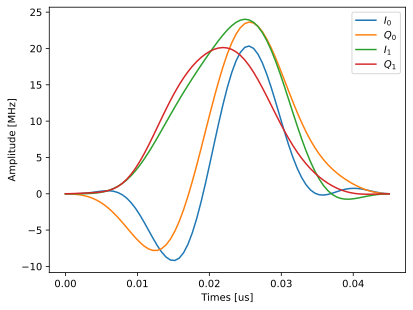

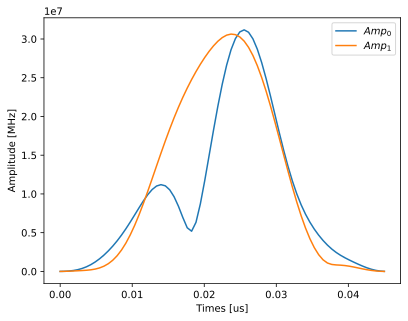

In [365]:
# pulse_filename = yaml_cfg.device.qubit.pulses.pulse_pp.filename
# pulse_filename = yaml_cfg.device.qubit.pulses.pulse_1p.filename
pulse_filename = yaml_cfg.device.qubit.pulses.pulse_p1.filename
pulse_filepath = os.path.join(os.getcwd(), pulse_filename + '.npz')
print(pulse_filename)

pulse_params_dict = dict() # open file
with np.load(pulse_filepath) as npzfile:
    for key in npzfile.keys():
        pulse_params_dict.update({key:npzfile[key]})

print(pulse_params_dict.keys())
IQ_qubits = [0, 1]
print('IQ_qubits', IQ_qubits)

times = pulse_params_dict['times']
I_0 = pulse_params_dict['I_0']
Q_0 = pulse_params_dict['Q_0']
I_1 = pulse_params_dict['I_1']
Q_1 = pulse_params_dict['Q_1']
plt.figure()
plt.plot(times*1e6, I_0*1e-6, label='$I_0$')
plt.plot(times*1e6, Q_0*1e-6, label='$Q_0$')
plt.plot(times*1e6, I_1*1e-6, label='$I_1$')
plt.plot(times*1e6, Q_1*1e-6, label='$Q_1$')
plt.legend()
plt.xlabel('Times [us]')
plt.ylabel('Amplitude [MHz]')
plt.show()

plt.figure()
plt.plot(times*1e6, np.abs(I_0+1j*Q_0), label='$Amp_0$')
plt.plot(times*1e6, np.abs(I_1+1j*Q_1), label='$Amp_1$')
plt.legend()
plt.xlabel('Times [us]')
plt.ylabel('Amplitude [MHz]')
plt.show()

I_values_MHz = np.array([I_0, I_1])*1e-6
Q_values_MHz = np.array([Q_0, Q_1])*1e-6
times_us = times*1e6

In [366]:
tomo_qubits = [0, 1] # which qubits to do tomo on

# init_state = '|0+1>|0+1>' # this is just for reference when doing the 2Q tomo comparison
# init_state = '|1>|0+1>' # this is just for reference when doing the 2Q tomo comparison
init_state = '|0+1>|1>' # this is just for reference when doing the 2Q tomo comparison

readout_cool = True

In [367]:
centers = [3000, 5200]
spans = [2000, 2000]
# spans = [500, 500]
npts = [6, 6]

# centers = [4100, 5100]
# spans = [0, 0]
# npts = [1, 1]

centers = np.array(centers)
spans = np.array(spans)
npts = np.array(npts)
print('number points', (npts[0]+1)*(npts[1]+1))

tomoExpt = meas.OptimalCtrlTomo2QExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"OptimalCtrlTomo2Q_{tomo_qubits[0]}{tomo_qubits[1]}",
    config_file=config_path,
)

tomoExpt.cfg.expt = dict(
    starts=(centers-spans/2).astype(int), # start gain for each qubit in IQ_qubits
    steps=(spans/npts).astype(int),
    expts=npts+1,
    reps=5000, # reps per measurement basis
    # reps=100, # reps per measurement basis
    singleshot_reps=15000, # reps for single shot calib
    # singleshot_reps=1000, # reps for single shot calib
    tomo_qubits=tomo_qubits,
    
    Icontrols=I_values_MHz, # 2D array with array of Icontrols for each of IQ_qubits
    Qcontrols=Q_values_MHz, # 2D array with array of Qcontrols for each of IQ_qubits
    times_us=times_us,
    IQ_qubits=IQ_qubits,
    
    readout_cool=readout_cool,
    n_init_readout=1,
    n_trig=1,
    init_read_wait_us=10,
   
    # thresholds=[530.1641328860773, 298.0622274040452, 0, 0],
    # angles=[-156.06235175077572, -177.6596617753593, 0, 0],
    # ge_avgs=[[-442.594915, -279.7363071627907, -914.3632173488371, -39.117149279069764], [-177.4867981416169, 198.44441421595226, -387.54766318502436, 200.4889138632664], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
    # counts_calib=[[15698, 2664, 1281, 357], [3353, 14690, 562, 1395], [1904, 406, 14898, 2792], [820, 1603, 3297, 14280]]
)

# print(tomoExpt.cfg)
import Pyro4.util
try:
    tomoExpt.acquire(progress=True, debug=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

number points 49
gainpts Q0 [2000 2333 2666 2999 3332 3665 3998]
gainpts Q1 [4200 4533 4866 5199 5532 5865 6198]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 76.66922230741025 	 angle (deg): 26.03327721940717 	 threshold ge: 312.0803289891335
Qubit (1)
ge fidelity (%): 53.900000000000006 	 angle (deg): -173.43104307957515 	 threshold ge: 408.0059907231424


  0%|          | 0/2 [00:00<?, ?it/s]

Qubit (2) ge
ge fidelity (%): 80.14 	 angle (deg): 155.72747849360348 	 threshold ge: 490.2627886037599


  0%|          | 0/2 [00:00<?, ?it/s]

Qubit (3) ge
ge fidelity (%): 75.26666666666667 	 angle (deg): 29.431008995938555 	 threshold ge: 76.64195865903628
thresholds=[312.0803289891335, 408.0059907231424, 490.2627886037599, 76.64195865903628],
angles=[26.03327721940717, -173.43104307957515, 155.72747849360348, 29.431008995938555],
ge_avgs=[[199.03519633969907, 85.0020259837963, 540.181451461227, -83.35677699652778], [-296.75081434461805, -95.21728838975694, -508.2667942274306, -68.54649733072917], [-123.88178407118056, -398.12985993923616, -510.5924571180556, -594.4715744791666], [179.27013018663197, 433.4731576171875, 500.20205553385415, 250.7809875]],
counts_calib=[[11409, 2199, 970, 422], [3815, 9681, 522, 982], [1715, 394, 9893, 2998], [817, 1527, 2300, 10356]]


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

In [368]:
pulse_dict = tomoExpt.pulse_dict
tomoExpt.save_data()

Saving S:\Connie\experiments\qramLL_4QR2\data\data_240617\00220_OptimalCtrlTomo2Q_01.h5


'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00220_OptimalCtrlTomo2Q_01.h5'

In [369]:
apply_ps = True
ps_adjust = [-0.3, -1.0, -0.3, -0.3]
# ps_adjust = [np.inf]*4
ps_qubits = [0, 1, 2, 3]

init_state |0+1>|1>
Using evol mats from file S:\Connie\experiments\qramLL_4QR2\evol_mats\evol_mats_01.npz
2000 4200 fid 0.7900935947103881 purity 0.9264454457985281
2000 4533 fid 0.7252161930390134 purity 0.8231540847372207


 S:\Connie\experiments\qramLL_4QR2\TomoAnalysis.py: 757ComplexWarning: Casting complex values to real discards the imaginary part
 S:\Connie\experiments\qramLL_4QR2\TomoAnalysis.py: 762

2000 4866 fid 0.8096309724414746 purity 0.8898649511788913
2000 5199 fid 0.8350459024922657 purity 0.8867231663415802
2000 5532 fid 0.8672691344765677 purity 0.9323344636694888
2000 5865 fid 0.7098493244203479 purity 0.7273143716327338
2000 6198 fid 0.82624686324649 purity 0.9152988591225367
2333 4200 fid 0.8246409787190135 purity 0.9999999999999989
2333 4533 fid 0.8786613117637943 purity 0.9917800380852212
2333 4866 fid 0.8295685160958223 purity 0.7779749029279631
2333 5199 fid 0.8980605779608543 purity 0.9434951297632973
2333 5532 fid 0.8454612584773566 purity 0.84982735787441
2333 5865 fid 0.8277355548988974 purity 0.8739597963854973
2333 6198 fid 0.8006882533941494 purity 0.8561253487969542
2666 4200 fid 0.7518277412037819 purity 1.0000000000000002
2666 4533 fid 0.8515566056677963 purity 0.8583551170326805
2666 4866 fid 0.8813545311852964 purity 0.8821644736850136
2666 5199 fid 0.9007145082293949 purity 0.9316244804477191
2666 5532 fid 0.9042071647230624 purity 0.922449755467669
26

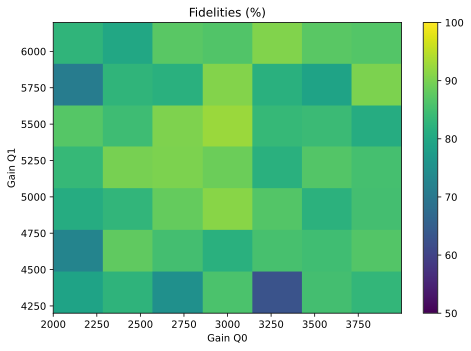

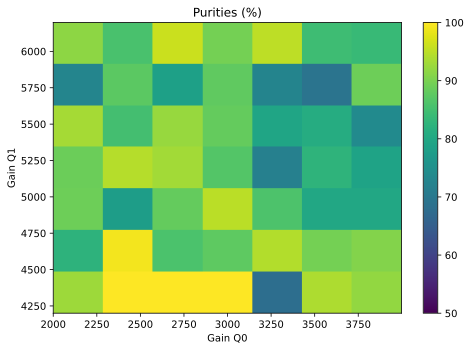

In [370]:
tomo = tomoExpt

# rho_id = qt.ket2dm((psi00 + psi01 + psi10 + psi11).unit())
print('init_state', init_state)
rho_id = qt.ket2dm(name_to_state_2q(init_state))

# filename = 'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00023_OptimalCtrlTomo2Q_01.h5'
# tomo = meas.OptimalCtrlTomo2QExperiment(config_file=config_path)
# data, attrs = prev_data(filename, None)
# tomo.data = data
# tomo.cfg = AttrDict(attrs['config'])
# pulse_dict = attrs['pulse_dict']

q0, q1 = tomo_qubits
evol_mats_file_path = os.path.join(evol_mats_path, evol_mats_filename)
print(f'Using evol mats from file {evol_mats_file_path}')

evol_mats = dict()
with np.load(evol_mats_file_path) as npzfile:
    for key in npzfile.keys():
        evol_mats.update({key:npzfile[key]})


data = tomo.data
cfg = tomo.cfg

gainpts0 = tomo.data['gainpts0']
gainpts1 = tomo.data['gainpts1']
fids_grid = np.zeros(shape=(len(gainpts1), len(gainpts0)))
purities_grid = np.zeros(shape=(len(gainpts1), len(gainpts0)))

for igain0, gain0 in enumerate(gainpts0):
    for igain1, gain1 in enumerate(gainpts1):
        if apply_ps:
            n_tomo_raw, n_calib = tomo_analysis.n_tomo_calib_from_data(
                data, cfg, ps_adjust=ps_adjust, ps_qubits=ps_qubits,
                ishots_raw=data['ishots_raw'][igain0, igain1], qshots_raw=data['qshots_raw'][igain0, igain1],
                apply_ps=apply_ps, verbose=False)
        else:
            n_tomo_raw = data['counts_tomo_gains'][igain0, igain1]
            n_calib = data['counts_calib']
        
        rho_MLE_ZZ = tomo_analysis.get_rho_from_counts(
            n_tomo_raw=n_tomo_raw,
            n_calib=n_calib,
            correct_readout=True,
            correct_neg_counts=True,
            method='analytical',
            ZZ_correction=True,
            evol_mats=evol_mats,
        )
        fid_ZZ = qt.fidelity(qt.Qobj(rho_MLE_ZZ, dims=rho_id.dims), rho_id)**2 # qutip uses N&C fidelity which is "sqrt fidelity"
        purity_ZZ = np.real(np.trace(rho_MLE_ZZ @ rho_MLE_ZZ))
        
        fids_grid[igain1, igain0] = fid_ZZ
        purities_grid[igain1, igain0] = purity_ZZ
        print(gain0, gain1, 'fid', fid_ZZ, 'purity', purity_ZZ)

x_sweep = gainpts0
y_sweep = gainpts1

plt.figure(figsize=(7,5))
plt.subplot(111, title=f"Fidelities (%)", ylabel=f"Gain Q{tomo.cfg.expt.IQ_qubits[1]}")
plt.imshow(
    np.flip(fids_grid*100, 0),
    cmap='viridis',
    extent=[x_sweep[0], x_sweep[-1], y_sweep[0], y_sweep[-1]],
    aspect='auto')
plt.colorbar()
plt.clim(vmin=50, vmax=100)
plt.xlabel(f'Gain Q{tomo.cfg.expt.IQ_qubits[0]}')
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,5))
plt.subplot(111, title=f"Purities (%)", ylabel=f"Gain Q{tomo.cfg.expt.IQ_qubits[1]}")
plt.imshow(
    np.flip(purities_grid*100, 0),
    cmap='viridis',
    extent=[x_sweep[0], x_sweep[-1], y_sweep[0], y_sweep[-1]],
    aspect='auto')
plt.colorbar()
plt.clim(vmin=50, vmax=100)
plt.xlabel(f'Gain Q{tomo.cfg.expt.IQ_qubits[0]}')
plt.tight_layout()
plt.show()

Pick one gain to plot tomo for

In [371]:
gain0 = 3000 # x axis
gain1 = 5532 # y axis

tomo = tomoExpt
cfg = tomo.cfg

data = tomo.data
gainpts0 = tomo.data['gainpts0']
gainpts1 = tomo.data['gainpts1']
igain0 = np.argmin(np.abs(gainpts0-gain0)) 
igain1 = np.argmin(np.abs(gainpts1-gain1)) 
print('plotting at gain Q0', gainpts0[igain0], 'Q1', gainpts1[igain1])
print('expected fid', fids_grid[igain1, igain0])
print('expected purity', purities_grid[igain1, igain0])
# tomo = qramExpt

# data, attrs = prev_data(expt_path, '00062_qram_protocol.h5')
# pulse_dict = attrs['pulse_dict']
# assert np.all(np.array(attrs['meas_order']) == meas_order)
# assert np.all(np.array(attrs['calib_order']) == calib_order)

pulse_dict = tomo.pulse_dict
assert np.all(np.array(tomo.meas_order) == tomo_analysis.meas_order)
assert np.all(np.array(tomo.calib_order) == tomo_analysis.calib_order)

if apply_ps:
    n_tomo_raw, n_calib = tomo_analysis.n_tomo_calib_from_data(
        data, cfg, ps_adjust=ps_adjust, ps_qubits=ps_qubits,
        ishots_raw=data['ishots_raw'][igain0, igain1], qshots_raw=data['qshots_raw'][igain0, igain1],
        apply_ps=apply_ps, verbose=False)
else:
    n_tomo_raw = data['counts_tomo_gains'][igain0, igain1]
    n_calib = data['counts_calib']

np.set_printoptions(suppress=True)

print('Tomography counts')
print(n_tomo_raw)
print('Confusion matrix counts')
print(n_calib)
print('Confusion matrix corrected tomo matrix will be')
print(tomo_analysis.correct_readout_err(n_tomo_raw, n_calib))
# print('Negative counts corrected tomo matrix will be')
# print(tomo_analysis.fix_neg_counts(tomo_analysis.correct_readout_err(n_tomo_raw, n_calib)))

plotting at gain Q0 2999 Q1 5532
expected fid 0.9243577344888096
expected purity 0.8820013485423933
Tomography counts
[[ 200.  836.  161.  571.]
 [ 627.  456.  336.  395.]
 [ 577.  468.  319.  404.]
 [ 429. 1115.   58.  228.]
 [ 796.  700.  122.  154.]
 [ 792.  747.  143.  159.]
 [ 310. 1176.   72.  249.]
 [ 762.  680.  137.  172.]
 [ 769.  644.  149.  166.]]
Confusion matrix counts
[[4304.  812.  154.   67.]
 [1355. 3628.   60.  173.]
 [ 376.   90. 3683. 1054.]
 [ 151.  417.  819. 3805.]]
Confusion matrix corrected tomo matrix will be
[[-153.75047 1151.69445   55.8385   714.21752]
 [ 564.15601  460.84916  343.01288  399.98195]
 [ 508.45598  503.90887  325.99543  429.63972]
 [  16.26822 1518.45078    2.36374  230.91726]
 [ 702.85297  832.61935  100.31745  132.21024]
 [ 646.30038  872.67826  126.08352  122.93783]
 [-170.35711 1661.63803   22.89941  253.81967]
 [ 673.94588  818.80759  120.05849  155.18804]
 [ 709.0675   771.88676  141.4794   145.56635]]
Negative counts corrected tomo mat

## Qram experiment

In [85]:
# tomo_qubits = [0, 3] # which qubit/resonators to do tomo on
# tomo_qubits = [0, 2] # which qubit/resonators to do tomo on
tomo_qubits = [0, 2] # which qubit/resonators to do tomo on

In [86]:
save_data = True

In [87]:
init_state = '|1>|0>' # Q0/Q1 (switch, input)
# init_state = 'Q3Q0_|1>|1>'
# init_state = '|1>|0>' # Q0/Q1 (switch, input)
# init_state = 'Q2Q0_|1>|0>'
# init_state = '|1>|1>' # Q0/Q1 (switch, input)
# play_pulses = [2, 1, 4, 3] # 1: Q2/Q1 with Q0 in g, 2: Q3/Q1 with Q0 in e, 3: Q2 ef pulse, 4: Q3 ef pulse [2, 1, 4, 3]
# play_pulses = [2, 4] # 1: Q2/Q1 with Q0 in g, 2: Q3/Q1 with Q0 in e, 3: Q2 ef pulse, 4: Q3 ef pulse [2, 1, 4, 3]
# play_pulses = [1, 3] # 1: Q2/Q1 with Q0 in g, 2: Q3/Q1 with Q0 in e, 3: Q2 ef pulse, 4: Q3 ef pulse [2, 1, 4, 3]
play_pulses = [0] # 1: Q2/Q1 with Q0 in g, 2: Q3/Q1 with Q0 in e, 3: Q2 ef pulse, 4: Q3 ef pulse [2, 1, 4, 3]
# play_pulses = [2]*8 # 1: Q2/Q1 with Q0 in g, 2: Q3/Q1 with Q0 in e, 3: Q2 ef pulse, 4: Q3 ef pulse [2, 1, 4, 3]

use_IQ_pulse = True

readout_cool = True

# cool_qubits = [0, 1]
cool_qubits = None

post_select = False # this is not the readout post selection

# add_phase = True # phase for swaps
add_phase = False
print('init_state', init_state)
print('post select', post_select)

init_state |1>|0>
post select False


In [89]:
qramExpts = []
nrepeat = 1
print('TOMO QUBITS', tomo_qubits)
print('init state', init_state)
saved_files = []

for i in tqdm(range(nrepeat)):
    qramExpt = meas.QramProtocolExperiment(
        soccfg=soc,
        path=expt_path,
        config_file=config_path,
    )

    # span = 2.161196963262976 # total time [us]
    # span = 1.1659462011134218 # total time [us]
    span = np.inf
    npts = 1
    # span = 1.8 # total time [us]
    # npts = 120
    # span = 0.8 # total time [us]
    # npts = 10
    if span < np.inf: print('time step size [cycles]:', soc.us2cycles(span/npts))

    qramExpt.cfg.expt = dict(
        # start=0, # start protocol time [us],
        # step=span/npts, # time step [us], 
        # expts=npts+1, # number of different time experiments - added 1 to include 0 step and full span

        start=span,
        step=0,
        expts=1, # number of different time experiments

        reps=30000, # number of reps per time step,
        # singleshot_reps=100, # reps per state for singleshot calibration
        singleshot_reps=30000, # reps per state for singleshot calibration
        post_process='scale', # 'threshold', (uses single shot binning), 'scale' (scale by ge_avgs), or None
        tomo_2q=True, # True/False whether to do 2q state tomography on state at last time step
        tomo_qubits=tomo_qubits, # the qubits on which to do the 2q state tomo
        calib_apply_q1_pi2=False, # initialize Q1 to 0+1 for all calibrations
        init_state=init_state,
        play_pulses=play_pulses,
        cool_qubits=cool_qubits,
        
        use_IQ_pulse=use_IQ_pulse,
        plot_IQ=False,
        
        add_phase=add_phase,
        
        # readout_cool=readout_cool,
        # n_init_readout=1,
        # n_trig=1,
        # # init_read_wait_us=5,
        # init_read_wait_us=10,
        
        # Icontrols=I_values_MHz, # 2D array with array of Icontrols for each of IQ_qubits
        # Qcontrols=Q_values_MHz, # 2D array with array of Qcontrols for each of IQ_qubits
        # times_us=times_us,
        # IQ_qubits=IQ_qubits,
        # IQ_gain=[3700, 3950],
        
        # thresholds=[33.169103683345895, 37.49913270024612, 0, 0],
        # angles=[-24.579056838557847, 115.19639444481155, 0, 0],
        # ge_avgs=[[34.43056101813111, -9.525004532775455, 44.589988819153874, -4.651175313807532], [30.053312459336368, -50.17723301886793, 25.548312166558233, -59.65660634352635], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
        # counts_calib=[[12553, 5207, 1604, 636], [4673, 12956, 666, 1705], [2241, 876, 12383, 4500], [918, 2095, 4712, 12275]]
 
    )

    # print(qramExpt.cfg)

    import Pyro4.util
    try:
        qramExpt.acquire(progress=True, debug=False)
    except Exception:
        print("Pyro traceback:")
        print("".join(Pyro4.util.getPyroTraceback()))

    qramExpts.append(qramExpt)
    if save_data: saved_files.append(qramExpt.save_data())

TOMO QUBITS [0, 2]
init state |1>|0>


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 68.73 	 angle (deg): -173.9404814038502 	 threshold ge: 253.99523414757454
Qubit (2)
ge fidelity (%): 82.80666666666666 	 angle (deg): -58.53078149838787 	 threshold ge: 539.1647145446573
thresholds=[253.99523414757454, 0, 539.1647145446573, 0],
angles=[-173.9404814038502, 0, -58.53078149838787, 0],
ge_avgs=[[-143.03321891637734, -166.19326109664354, -469.9841520688658, -131.4859086154514], array([0., 0., 0., 0.]), [106.93396467013886, 279.6589427083333, 361.3042660373264, 695.2545557074652], array([0., 0., 0., 0.])],
counts_calib=[[24995, 1773, 3024, 208], [2818, 23873, 376, 2933], [5746, 415, 22261, 1578], [540, 5261, 2430, 21769]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [ 4732   352 23298  1618]
ZX [ 3361  3354 12089 11196]
ZY [ 3164  3423 12150 11263]
XZ [14572   993 13511   924]
XX [8024 7847 7403 6726]
XY [8217 7941 7150 6692]
YZ [15680  1074 12428   818]
YX [8596 8629 6511 6264]
YY [8589 8302 6690 6419]
Saving S:\QRAM\qram_4QR2\data\data_240617\00140_qram_protocol.h5


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [03:07<00:00, 187.84s/it]


In [762]:
qramExpt.save_data()

Saving S:\Connie\experiments\qramLL_4QR2\data\data_240617\00134_qram_protocol.h5


'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00134_qram_protocol.h5'

### post processing average counts

In [90]:
apply_ps = False
ps_adjust = [-0.3, -1.0, -0.3, -0.3]
# ps_adjust = [np.inf]*4
ps_qubits = [0, 1, 2, 3]


postselect = False # this is not the readout post selection
postselect_state = 1 # select on Q1 being 0 (-) or 1 (+)

In [91]:
cfg = qramExpt.cfg
print('init state', qramExpt.cfg.expt.init_state)
n_tomo_raw_rounds = []
n_calib_rounds = []
n_tomo_rounds = []
for qramExpt in qramExpts:
    tomo = qramExpt
    data = tomo.data
    if postselect and qramExpt.cfg.expt.post_select:
        n_tomo_raw = np.array(data[f'counts_tomo_ps{postselect_state}'])
        n_calib = np.array(data['counts_calib'])
        print(f'Just getting states from post selection value of {postselect_state}')
    elif postselect and not qramExpt.cfg.expt.post_select:
        assert False, 'You are trying to post select but the experiment was not run with the post select flag=True!'
    elif qramExpt.cfg.expt.post_select:
        n_tomo_raw = np.array(data[f'counts_tomo_ps0'] + data[f'counts_tomo_ps1'])
        n_calib = np.array(data['counts_calib'])
    else:
        n_tomo_raw, n_calib = tomo_analysis.n_tomo_calib_from_data(data, cfg, ps_adjust=ps_adjust, ps_qubits=ps_qubits, apply_ps=apply_ps, verbose=True)
    
    n_tomo_raw_rounds.append(n_tomo_raw)
    n_calib_rounds.append(n_calib)

pulse_dict = qramExpts[-1].pulse_dict
# print(pulse_dict)

init state |1>|0>


In [92]:
n_tomo_raw = np.average(n_tomo_raw_rounds, axis=0)
n_tomo_raw_std = np.std(n_tomo_raw_rounds, axis=0)
n_calib = np.average(n_calib_rounds, axis=0)
n_calib_std = np.std(n_calib_rounds, axis=0)
n_tomo_avg = np.average(n_tomo_rounds, axis=0)
n_tomo_std = np.std(n_tomo_rounds, axis=0)
# n_tomo_corrected = tomo_analysis.fix_neg_counts(tomo_analysis.correct_readout_err(n_tomo_raw, n_calib))
print('num rounds', len(n_tomo_raw_rounds))

print('Measure order', tomo_analysis.meas_order)

print('Average raw tomography counts')
for r in range(n_tomo_raw.shape[0]):
    n_tomo_raw[r,:]/=np.sum(n_tomo_raw[r,:])
print(n_tomo_raw)
# print('Std raw tomography counts')
# print(n_tomo_raw_std)
print('Average confusion matrix counts')
for r in range(n_calib.shape[0]):
    n_calib[r,:]/=np.sum(n_calib[r,:])
print(n_calib)
print('Corrected counts')
print(np.around(tomo_analysis.correct_readout_err(n_tomo_raw, n_calib), decimals=3))
# print('Std confusion matrix counts')
# print(n_calib_std)
# print('Average n_tomo')
# print(n_tomo_avg)
# print('Std n_tomo')
# print(n_tomo_std)
# print('Corrected average tomo with average calib counts, corrected for neg counts')
# print(n_tomo_corrected)

# n_tomo = n_tomo_avg
# print(pulse_dict['ZX'].keys())
# print(pulse_dict['ZX']['Yhalf_q1'])
# print(pulse_dict['ZX']['Xhalf_q1'])

 C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py: 520RuntimeWarning: invalid value encountered in scalar divide
 C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py: 129RuntimeWarning: Degrees of freedom <= 0 for slice
 C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py: 206RuntimeWarning: invalid value encountered in divide
 C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py: 163RuntimeWarning: invalid value encountered in scalar divide
 C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py: 198

num rounds 1
Measure order ['ZZ' 'ZX' 'ZY' 'XZ' 'XX' 'XY' 'YZ' 'YX' 'YY']
Average raw tomography counts
[[0.15773333 0.01173333 0.7766     0.05393333]
 [0.11203333 0.1118     0.40296667 0.3732    ]
 [0.10546667 0.1141     0.405      0.37543333]
 [0.48573333 0.0331     0.45036667 0.0308    ]
 [0.26746667 0.26156667 0.24676667 0.2242    ]
 [0.2739     0.2647     0.23833333 0.22306667]
 [0.52266667 0.0358     0.41426667 0.02726667]
 [0.28653333 0.28763333 0.21703333 0.2088    ]
 [0.2863     0.27673333 0.223      0.21396667]]
Average confusion matrix counts
[[0.83316667 0.0591     0.1008     0.00693333]
 [0.09393333 0.79576667 0.01253333 0.09776667]
 [0.19153333 0.01383333 0.74203333 0.0526    ]
 [0.018      0.17536667 0.081      0.72563333]]
Corrected counts
[[-0.     0.     1.     0.   ]
 [ 0.009  0.027  0.49   0.475]
 [-0.     0.029  0.493  0.478]
 [ 0.457 -0.     0.543 -0.   ]
 [ 0.225  0.251  0.27   0.253]
 [ 0.235  0.255  0.257  0.252]
 [ 0.514 -0.     0.486  0.   ]
 [ 0.254  0.288  

Plot single shot blobs for various bases

In [93]:
tomo = qramExpt

In [94]:
q = 0
plot_bases = ['ZZ']

data = tomo.data
check_states = []

iprep_g = 0
if q == tomo.cfg.expt.tomo_qubits[0]: iprep_e = 2
else: iprep_e = 1
iprep_ee = 3

data['iqshots'] = []
data['iqshots'].append((data[f'calib_ishots_raw'][iprep_g, :, -1, :], data[f'calib_qshots_raw'][iprep_g, :, -1, :]))
check_states.append('g')
data['iqshots'].append((data[f'calib_ishots_raw'][iprep_e, :, -1, :], data[f'calib_qshots_raw'][iprep_e, :, -1, :]))
check_states.append('e')
data['iqshots'].append((data[f'calib_ishots_raw'][iprep_ee, :, -1, :], data[f'calib_qshots_raw'][iprep_ee, :, -1, :]))
check_states.append('ee')

for basis in plot_bases:
    ibasis = np.where(tomo_analysis.meas_order == basis)[0][0]
    data['iqshots'].append((data[f'ishots_raw'][ibasis, :, -1, :], data[f'qshots_raw'][ibasis, :, -1, :]))
    check_states.append(basis)

play_pulses_list = [] # this is just so we don't print play pulses in the multihist
for check_state in check_states:
    play_pulses_list.append([0])
g_states = [0]
e_states = [1]

meas.single_qubit.single_shot.multihist(
    title=f'Single Shot Q{q} with Multi Readout',
    data=data, check_qubit=q, check_states=check_states, play_pulses_list=play_pulses_list, g_states=g_states, e_states=e_states,
    plot=True, export=True)

g play_pulses [0] unrotated averages:
I -143.03321891637734 +/- 142.35739126066397 	 Q -166.19326109664354 +/- 97.5896769644081 	 Amp 219.26856078224588
Rotated (theta=-3.0358341030011546):
I 124.69044830813225 +/- 142.60945331838806 	 Q 180.36350475701684 +/- 97.22096338130879 	 Amp 219.26856078224586
e play_pulses [0] unrotated averages:
I -469.9841520688658 +/- 206.78470799605503 	 Q -131.4859086154514 +/- 96.75393137955547 	 Amp 488.0303754484157
Rotated (theta=-3.0358341030011546):
I 453.47839365518524 +/- 207.18984765872005 	 Q 180.36350475701684 +/- 95.88329221282422 	 Amp 488.0303754484157
ee play_pulses [0] unrotated averages:
I -483.6348577256944 +/- 208.59008934740697 	 Q -132.47378679832175 +/- 95.46529267715037 	 Amp 501.4498776508375
Rotated (theta=-3.0358341030011546):
I 466.9485478353024 +/- 208.80098946222472 	 Q 182.78685256478997 +/- 95.00312773529677 	 Amp 501.44987765083755
ZZ play_pulses [0] unrotated averages:
I -500.1983028790509 +/- 204.21540038198205 	 Q -131.

([0.6875333333333331], [250.28426307474513], -173.9404814038502)

In [ ]:
# n_tomo = np.array( # |0>(|0+1>)
# [[7000,    0,    0,    0.],
#  [3792, 3073,  136,    0.],
#  [3970, 2784,    0,  247.],
#  [2472,    0, 4528,    0.],
#  [1411, 1199, 2044, 2346.],
#  [1533, 1196, 1949, 2322.],
#  [2195,    0, 4805,    0.],
#  [1624, 1141, 1970, 2265.],
#  [1549, 1185, 2072, 2193.]]
# )
 
# n_tomo = np.array( # |1>(|0+1>)
# [[ 971, 2621, 3408,    0.],
#  [1845, 2063, 1577, 1515.],
#  [1916, 1949, 1368, 1767.],
#  [2170,  999, 2005, 1825.],
#  [1757, 1430, 1434, 2378.],
#  [1457, 1758, 1643, 2142.],
#  [2217, 1055, 1985, 1743.],
#  [1738, 1478, 1332, 2453.],
#  [1841, 1476, 1305, 2378.]]
# )

# n_tomo = np.array( # (|0+1>)(|0+1>)
# [[3569, 1651, 1780,    0.],
#  [2896, 2730,  880,  495.],
#  [2897, 2727,  773,  603.],
#  [2200,  737, 3594,  470.],
#  [1630, 1303, 2016, 2051.],
#  [1626, 1360, 1906, 2108.],
#  [2408,  460, 3146,  987.],
#  [1430, 1641, 2026, 1904.],
#  [1478, 1387, 1767, 2368.]]
# )

# n_tomo = np.array( # (|0+i1>)(|0+1>)
# [[3163., 2173., 1664.,    0.],
#  [2438., 3299.,  806.,  456.],
#  [2627., 3226.,  722.,  425.],
#  [1857., 1092., 3028., 1023.],
#  [1242., 1632., 1695., 2431.],
#  [1469., 1365., 1518., 2647.],
#  [1980.,  885., 2896., 1239.],
#  [1300., 1627., 1468., 2605.],
#  [ 963., 1985., 1752., 2300.]])


## Big qram protocol loop!

In [559]:
init_states = ['|0+1>|0>', '|0>|0+1>', '|1>|0+1>', '|0+1>|1>', '|0+1>|0+1>', '|0>|0>', '|1>|0>', '|1>|1>', '|0>|1>']
# init_states = ['|1>|0+1>', '|0+1>|1>', '|0+1>|0+1>', '|0>|0>', '|0>|1>']
# init_states = ['|0+1>|0>', '|0>|0+1>', '|1>|0+1>', '|0+1>|1>']
# init_states = ['|0>|1>']
# init_states = ['|0+1>|0+1>']
protocol_play = [0] # 1: Q2/Q1 with Q0 in g, 2: Q3/Q1 with Q0 in e, 3: Q2 ef pulse, 4: Q3 ef pulse [2, 1, 4, 3]
# init_pulse_play = [0]

readout_cool = True

tomo_qubits = [0, 1] # which qubit/resonators to do tomo on

cool_qubits = None
# cool_qubits = [0, 1]

save_data = True
saved_files = []

In [560]:
play_pulses = protocol_play
for init_state in init_states:
    print('init_state', init_state, 'play pulses', play_pulses)
    qramExpt = meas.QramProtocolExperiment(
        soccfg=soc,
        path=expt_path,
        config_file=config_path,
    )
    
    span = np.inf
    npts = 1
    if span < np.inf: print('time step size [cycles]:', soc.us2cycles(span/npts))
    
    qramExpt.cfg.expt = dict(
        start=span,
        step=0,
        expts=1, # number of different time experiments
    
        reps=30000, # number of reps per tomo/time step,
        singleshot_reps=30000, # reps per state for singleshot calibration
        post_process=None, # 'threshold', (uses single shot binning), 'scale' (scale by ge_avgs), or None
        tomo_2q=True, # flag to perform tomo on last time step
        tomo_qubits=tomo_qubits, # the qubits on which to do the 3q state tomo
        calib_apply_q1_pi2=False, # initialize Q1 to 0+1 for all calibrations
        init_state=init_state,
        play_pulses=play_pulses, # [2, 1, 4, 3]
        cool_qubits=cool_qubits,
        
        use_IQ_pulse=True,
        plot_IQ=False,
        
        readout_cool=readout_cool,
        n_init_readout=1,
        n_trig=1,
        init_read_wait_us=10,
    )

    import Pyro4.util
    success = False
    while not success:
        try:
            qramExpt.acquire(progress=True, debug=False)
            success = True
        except Exception:
            print("Pyro traceback:")
            print("".join(Pyro4.util.getPyroTraceback()))
    
    if save_data: saved_files.append(qramExpt.save_data())

init_state |0+1>|0> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 78.67 	 angle (deg): 61.99269795049348 	 threshold ge: 255.7106464851518
Qubit (1)
ge fidelity (%): 61.63999999999999 	 angle (deg): -159.03408503431916 	 threshold ge: 392.2362391666361


  0%|          | 0/2 [00:00<?, ?it/s]

Qubit (2) ge
ge fidelity (%): 84.66666666666667 	 angle (deg): -135.1185162121048 	 threshold ge: 521.0715066223734


  0%|          | 0/2 [00:00<?, ?it/s]

Qubit (3) ge
ge fidelity (%): 76.97128285471425 	 angle (deg): 41.52443656069289 	 threshold ge: 44.67239744673975
thresholds=[255.7106464851518, 392.2362391666361, 521.0715066223734, 44.67239744673975],
angles=[61.99269795049348, -159.03408503431916, -135.1185162121048, 41.52443656069289],
ge_avgs=[[233.3060269314236, 4.4935763527199075, 418.8016988208912, -341.33300859375], [-276.40349106987844, 36.530203005642356, -490.3397841145833, 119.03427966579862], [-254.7671681640625, 147.51112233072917, -600.2606565104167, 490.75810611979165], [263.4969426052517, 402.8818762586806, 536.816871999783, 160.31356148003474]],
counts_calib=[[23340, 4716, 1510, 434], [5811, 22433, 557, 1199], [3525, 957, 20139, 5379], [2519, 8703, 4824, 13954]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [13295  2859 10914  2932]
ZX [8680 8961 7608 4751]
ZY [8908 8901 7568 4623]
XZ [23351  4543  1486   620]
XX [14380 13621  1006   993]
XY [14545 13425  1090   940]
YZ [13561  2980 10747  2712]
YX [9053 8390 7424 5133]
YY [9090 8690 7403 4817]
Saving S:\Connie\experiments\qramLL_4QR2\data\data_240617\00116_qram_protocol.h5
init_state |0>|0+1> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 77.05666666666666 	 angle (deg): 59.463617845761256 	 threshold ge: 252.33002214878587
Qubit (1)
ge fidelity (%): 61.317688628143806 	 angle (deg): -158.9179998728664 	 threshold ge: 379.37295035434073


  0%|          | 0/2 [00:00<?, ?it/s]

Qubit (2) ge
ge fidelity (%): 85.35475591259855 	 angle (deg): -132.91055409276922 	 threshold ge: 522.6845400787944


  0%|          | 0/2 [00:00<?, ?it/s]

Qubit (3) ge
ge fidelity (%): 77.19666666666667 	 angle (deg): 40.398437289290094 	 threshold ge: 43.01430043309921
thresholds=[252.33002214878587, 379.37295035434073, 522.6845400787944, 43.01430043309921],
angles=[59.463617845761256, -158.9179998728664, -132.91055409276922, 40.398437289290094],
ge_avgs=[[232.0377818070023, 12.172181061921298, 426.16191867042824, -315.33014594184027], [-276.27329204644093, 37.938446831597226, -487.8172137803819, 119.82834639756945], [-244.87056974826388, 156.913171484375, -578.526601453993, 515.6874771701389], [250.58687240668402, 419.57764321831587, 530.3499011284723, 179.45707969835073]],
counts_calib=[[22561, 5436, 1501, 502], [5166, 23016, 550, 1268], [3742, 1177, 19123, 5958], [2125, 8984, 4777, 14114]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [13995 14208   874   923]
ZX [22729  5526  1128   617]
ZY [13534 14681  1015   770]
XZ [8508 9785 6355 5352]
XX [12649  5400  6260  5691]
XY [8347 8513 9585 3555]
YZ [8580 9920 6194 5306]
YX [13053  5637  5959  5351]
YY [8223 8624 9594 3559]
Saving S:\Connie\experiments\qramLL_4QR2\data\data_240617\00117_qram_protocol.h5
init_state |1>|0+1> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 79.18131968866147 	 angle (deg): 57.778273230776975 	 threshold ge: 255.23147662481472
Qubit (1)
ge fidelity (%): 61.67333333333333 	 angle (deg): -159.6571812216462 	 threshold ge: 382.7602899568368


  0%|          | 0/2 [00:00<?, ?it/s]

Qubit (2) ge
ge fidelity (%): 84.8947482458041 	 angle (deg): -130.61417364723147 	 threshold ge: 515.667816787602


  0%|          | 0/2 [00:00<?, ?it/s]

Qubit (3) ge
ge fidelity (%): 77.19461991033184 	 angle (deg): 37.24018725382995 	 threshold ge: 36.97369263489924
thresholds=[255.23147662481472, 382.7602899568368, 515.667816787602, 36.97369263489924],
angles=[57.778273230776975, -159.6571812216462, -130.61417364723147, 37.24018725382995],
ge_avgs=[[235.57383355758103, 24.524152379918984, 447.32472097077545, -310.0656343605324], [-274.87429325086805, 36.90653353949652, -490.81909688585074, 115.58617923177083], [-240.04099596354166, 165.83838383246527, -557.063615451389, 537.1844637152777], [227.9055643337674, 429.0878656901042, 521.5749783582899, 203.93571342773438]],
counts_calib=[[22881, 5205, 1382, 532], [5337, 23093, 450, 1120], [3292, 1054, 19809, 5845], [2152, 8545, 4790, 14513]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [ 2598  4328 12700 10374]
ZX [ 3759  2733 15693  7815]
ZY [ 3804  2527 16841  6828]
XZ [8035 8863 7289 5813]
XX [10721  7474  4714  7091]
XY [10879  4817  9920  4384]
YZ [7994 8101 7674 6231]
YX [9435 7379 5085 8101]
YY [ 9790  4312 11153  4745]
Saving S:\Connie\experiments\qramLL_4QR2\data\data_240617\00118_qram_protocol.h5
init_state |0+1>|1> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 77.15461924365407 	 angle (deg): 54.357211337182086 	 threshold ge: 259.1430081251228
Qubit (1)
ge fidelity (%): 61.68666666666667 	 angle (deg): -157.00893701225533 	 threshold ge: 378.7846771975786


  0%|          | 0/2 [00:00<?, ?it/s]

Qubit (2) ge
ge fidelity (%): 84.61666666666666 	 angle (deg): -129.72324239757702 	 threshold ge: 515.9581976830234


  0%|          | 0/2 [00:00<?, ?it/s]

Qubit (3) ge
ge fidelity (%): 77.87463124385407 	 angle (deg): 34.73819326021216 	 threshold ge: 30.265177136577393
thresholds=[259.1430081251228, 378.7846771975786, 515.9581976830234, 30.265177136577393],
angles=[54.357211337182086, -157.00893701225533, -129.72324239757702, 34.73819326021216],
ge_avgs=[[237.60882003761574, 24.46751062644676, 463.26665004340276, -289.91648964120367], [-279.59378824869793, 29.55165559895833, -490.973642719184, 118.26742881944446], [-220.9822187934028, 185.4915606987847, -530.387549826389, 557.9031651041666], [205.10837311197918, 439.7716825846354, 514.3568838053385, 223.1989672580295]],
counts_calib=[[22508, 4861, 1650, 981], [4966, 22573, 711, 1750], [3233, 1000, 19837, 5930], [1986, 8145, 4677, 15192]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [ 3825 17190  2162  6823]
ZX [ 8990 10811  5048  5151]
ZY [ 8998 11127  5036  4839]
XZ [ 4718 21087  1060  3135]
XX [11931 13413  2087  2569]
XY [12242 13146  2166  2446]
YZ [ 4271 20890  1403  3436]
YX [12017 12735  2582  2666]
YY [12033 12768  2559  2640]
Saving S:\Connie\experiments\qramLL_4QR2\data\data_240617\00119_qram_protocol.h5
init_state |0+1>|0+1> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 80.03800063334388 	 angle (deg): 51.88519312260511 	 threshold ge: 263.0927648564907
Qubit (1)
ge fidelity (%): 62.406666666666666 	 angle (deg): -158.92595969816392 	 threshold ge: 384.1019276288537


  0%|          | 0/2 [00:00<?, ?it/s]

Qubit (2) ge
ge fidelity (%): 84.73 	 angle (deg): -127.15002940404774 	 threshold ge: 522.1180258190334


  0%|          | 0/2 [00:00<?, ?it/s]

Qubit (3) ge
ge fidelity (%): 77.16257208573619 	 angle (deg): 33.55508841414344 	 threshold ge: 29.53103315418298
thresholds=[263.0927648564907, 384.1019276288537, 522.1180258190334, 29.53103315418298],
angles=[51.88519312260511, -158.92595969816392, -127.15002940404774, 33.55508841414344],
ge_avgs=[[226.66108676938657, 38.533303899016204, 474.6609106409144, -275.28809364149305], [-272.9050522786459, 33.21711031901042, -490.16844459635416, 116.8606771375868], [-216.38348276909724, 193.10174270833335, -508.74536907552084, 578.4401151041667], [199.34154855685765, 449.44706475151906, 504.76359927842884, 245.0211418077257]],
counts_calib=[[23219, 4857, 1437, 487], [5434, 22775, 530, 1261], [3180, 926, 20168, 5726], [2249, 9123, 4481, 14147]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [9985 8334 7594 4087]
ZX [13944  4136  8361  3559]
ZY [9296 8264 9069 3371]
XZ [16509 10798  1272  1421]
XX [21368  5964  1558  1110]
XY [16329 10999  1464  1208]
YZ [9607 8963 7897 3533]
YX [13604  5923  5793  4680]
YY [11344  6310  9164  3182]
Saving S:\Connie\experiments\qramLL_4QR2\data\data_240617\00120_qram_protocol.h5
init_state |0>|0> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 73.50666666666666 	 angle (deg): 49.50396133599738 	 threshold ge: 245.3579189211398
Qubit (1)
ge fidelity (%): 62.2843714061901 	 angle (deg): -158.81087717426362 	 threshold ge: 379.9667506011606


  0%|          | 0/2 [00:00<?, ?it/s]

Qubit (2) ge
ge fidelity (%): 84.80808013466891 	 angle (deg): -125.25399306793346 	 threshold ge: 523.1689369449714


  0%|          | 0/2 [00:00<?, ?it/s]

Qubit (3) ge
ge fidelity (%): 76.80128002133368 	 angle (deg): 30.15496409057257 	 threshold ge: 47.65655965255604
thresholds=[245.3579189211398, 379.9667506011606, 523.1689369449714, 47.65655965255604],
angles=[49.50396133599738, -158.81087717426362, -125.25399306793346, 30.15496409057257],
ge_avgs=[[223.87990455729167, 49.207600549768514, 457.3512055700231, -224.57678579282407], [-271.21331283637153, 30.870785796440973, -488.3626032660591, 115.82493889973959], [-206.3569037109375, 197.8420740234375, -486.8678647786458, 598.5971145399305], [176.5948889105903, 453.55253520507813, 493.3075845703125, 267.54241666666667]],
counts_calib=[[22854, 4945, 1658, 543], [5270, 22605, 574, 1551], [4467, 1284, 18749, 5500], [2463, 10593, 4098, 12846]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [22648  5059  1699   594]
ZX [13906 13971  1086  1037]
ZY [13895 13956  1063  1086]
XZ [13148  3019 10587  3246]
XX [8450 9270 7232 5048]
XY [8266 9194 7336 5204]
YZ [13226  3011 10500  3263]
YX [8534 9144 7272 5050]
YY [8241 9196 7399 5164]
Saving S:\Connie\experiments\qramLL_4QR2\data\data_240617\00121_qram_protocol.h5
init_state |1>|0> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 77.67796129935499 	 angle (deg): 47.738343244929624 	 threshold ge: 255.9352427102865
Qubit (1)
ge fidelity (%): 61.743333333333325 	 angle (deg): -160.34448347227962 	 threshold ge: 387.94994279139854


  0%|          | 0/2 [00:00<?, ?it/s]

Qubit (2) ge
ge fidelity (%): 84.94333333333334 	 angle (deg): -121.86051516422422 	 threshold ge: 531.9613681119537


  0%|          | 0/2 [00:00<?, ?it/s]

Qubit (3) ge
ge fidelity (%): 75.80333333333333 	 angle (deg): 31.083638922109298 	 threshold ge: 39.93320830232517
thresholds=[255.9352427102865, 387.94994279139854, 531.9613681119537, 39.93320830232517],
angles=[47.738343244929624, -160.34448347227962, -121.86051516422422, 31.083638922109298],
ge_avgs=[[227.33902647569445, 62.150305620659715, 485.1739387586806, -220.95562878327547], [-272.8492375325521, 36.91087909071181, -491.8729274739583, 114.39459946831599], [-201.4674475477431, 207.76068932291668, -458.48529867621534, 620.6717792100695], [181.80845116644963, 468.9052858940973, 483.0161145345052, 284.8409281195746]],
counts_calib=[[23194, 4862, 1468, 476], [5563, 22263, 611, 1563], [3662, 1106, 19691, 5541], [2184, 8438, 4693, 14685]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [ 3312  1099 19993  5596]
ZX [ 2830  4470 13720  8980]
ZY [ 3027  4828 13763  8382]
XZ [13214  2736 10760  3290]
XX [8440 8909 7556 5095]
XY [8573 8654 7570 5203]
YZ [12338  2820 11538  3304]
YX [8032 8586 8129 5253]
YY [8314 8826 7834 5026]
Saving S:\Connie\experiments\qramLL_4QR2\data\data_240617\00122_qram_protocol.h5
init_state |1>|1> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 78.97999999999999 	 angle (deg): 44.391310768902194 	 threshold ge: 262.4472572018271
Qubit (1)
ge fidelity (%): 62.52333333333333 	 angle (deg): -158.0879756934883 	 threshold ge: 381.27329417931685


  0%|          | 0/2 [00:00<?, ?it/s]

Qubit (2) ge
ge fidelity (%): 83.42805713428557 	 angle (deg): -120.0858941626886 	 threshold ge: 520.8370465288881


  0%|          | 0/2 [00:00<?, ?it/s]

Qubit (3) ge
ge fidelity (%): 76.6246104101735 	 angle (deg): 25.8248923216851 	 threshold ge: 56.58800368641192
thresholds=[262.4472572018271, 381.27329417931685, 520.8370465288881, 56.58800368641192],
angles=[44.391310768902194, -158.0879756934883, -120.0858941626886, 25.8248923216851],
ge_avgs=[[217.04166823640043, 65.63484401041667, 499.6918955656829, -211.18863861400467], [-275.4928624565972, 28.808845171440975, -490.48822849392366, 115.14080646701389], [-187.42143600260417, 221.89010579427082, -428.190753515625, 636.8527547743056], [141.3707046875, 465.8460633246528, 471.7399771104601, 302.4172171223958]],
counts_calib=[[23177, 4880, 1419, 524], [5363, 22910, 497, 1230], [3323, 1071, 19820, 5786], [2525, 10877, 4112, 12486]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [ 2335  9597  4480 13588]
ZX [ 2904  6426  9896 10774]
ZY [ 3087  6384  9683 10846]
XZ [ 3663 16160  2723  7454]
XX [ 8076 10367  5939  5618]
XY [8225 9548 5748 6479]
YZ [ 3425 16027  2989  7559]
YX [ 8156 10229  5882  5733]
YY [ 8142 10627  5483  5748]
Saving S:\Connie\experiments\qramLL_4QR2\data\data_240617\00123_qram_protocol.h5
init_state |0>|1> play pulses [0]
timesteps [inf]


  0%|          | 0/4 [00:00<?, ?it/s]

Qubit (0)
ge fidelity (%): 75.61666666666666 	 angle (deg): 41.15879581078901 	 threshold ge: 244.4401902884386
Qubit (1)
ge fidelity (%): 62.31770529508825 	 angle (deg): -158.45102399211243 	 threshold ge: 378.0038987503258


  0%|          | 0/2 [00:00<?, ?it/s]

Qubit (2) ge
ge fidelity (%): 84.49807496791614 	 angle (deg): -117.0957332560192 	 threshold ge: 510.4914749261941


  0%|          | 0/2 [00:00<?, ?it/s]

Qubit (3) ge
ge fidelity (%): 76.66666666666667 	 angle (deg): 23.53712251263854 	 threshold ge: 58.99106125197687
thresholds=[244.4401902884386, 378.0038987503258, 510.4914749261941, 58.99106125197687],
angles=[41.15879581078901, -158.45102399211243, -117.0957332560192, 23.53712251263854],
ge_avgs=[[209.59644755497686, 74.23561024305555, 490.8150970558449, -171.60511630497686], [-272.57139136284724, 31.16575946180555, -490.4907317925347, 117.98161909722224], [-178.15029546440974, 225.46370143229166, -399.38284661458334, 658.593222265625], [131.62836579861113, 469.40673877495664, 463.8100935112847, 324.47049384765626]],
counts_calib=[[22563, 5208, 1713, 516], [4989, 22904, 613, 1494], [3877, 1223, 18994, 5906], [2088, 9068, 4430, 14414]]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

ZZ [ 4948 22988   606  1458]
ZX [13625 14421   837  1117]
ZY [13193 14877   847  1083]
XZ [ 3468 16478  2385  7669]
XX [ 8169 10367  5820  5644]
XY [ 7869 10791  5296  6044]
YZ [ 3556 16422  2412  7610]
YX [ 8162 10063  5922  5853]
YY [ 7990 10929  5266  5815]
Saving S:\Connie\experiments\qramLL_4QR2\data\data_240617\00124_qram_protocol.h5


In [562]:
print(saved_files)

['S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00116_qram_protocol.h5', 'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00117_qram_protocol.h5', 'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00118_qram_protocol.h5', 'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00119_qram_protocol.h5', 'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00120_qram_protocol.h5', 'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00121_qram_protocol.h5', 'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00122_qram_protocol.h5', 'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00123_qram_protocol.h5', 'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00124_qram_protocol.h5']


In [458]:
saved_files = ['S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00088_qram_protocol.h5', 'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00099_qram_protocol.h5', 'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00090_qram_protocol.h5', 'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00091_qram_protocol.h5', 'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00097_qram_protocol.h5', 'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00096_qram_protocol.h5', 'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00094_qram_protocol.h5', 'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00098_qram_protocol.h5', 'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00100_qram_protocol.h5']

In [563]:
apply_ps = True
ps_adjust = [-0.3, -1.0, -0.3, -0.3]
# ps_adjust = [np.inf]*4
ps_qubits = [0, 1, 2, 3]

S:\Connie\experiments\qramLL_4QR2\data\data_240617\00116_qram_protocol.h5
S:\Connie\experiments\qramLL_4QR2\data\data_240617\00116_qram_protocol.h5


 C:\Users\slab\AppData\Local\Temp\ipykernel_12272\809401443.py: 13

Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']
init state (Q0 (switch) Q1 (input)): |0+1>|0>


 S:\Connie\experiments\qramLL_4QR2\TomoAnalysis.py: 912ComplexWarning: Casting complex values to real discards the imaginary part
 S:\Connie\experiments\qramLL_4QR2\TomoAnalysis.py: 917

Fidelity (with ZZ correction): 0.9660356990651384
Purity (with ZZ correction): 0.9382014787279473
Target purity: 0.9999999999999996


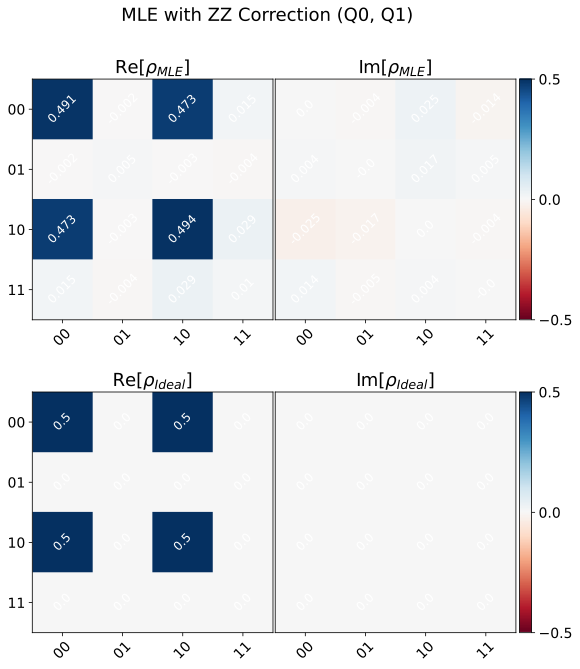





S:\Connie\experiments\qramLL_4QR2\data\data_240617\00117_qram_protocol.h5
S:\Connie\experiments\qramLL_4QR2\data\data_240617\00117_qram_protocol.h5


 C:\Users\slab\AppData\Local\Temp\ipykernel_12272\809401443.py: 13

Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']
init state (Q0 (switch) Q1 (input)): |0>|0+1>


 S:\Connie\experiments\qramLL_4QR2\TomoAnalysis.py: 912ComplexWarning: Casting complex values to real discards the imaginary part
 S:\Connie\experiments\qramLL_4QR2\TomoAnalysis.py: 917

Fidelity (with ZZ correction): 0.9651480722809278
Purity (with ZZ correction): 0.9408979288277165
Target purity: 0.9999999999999996


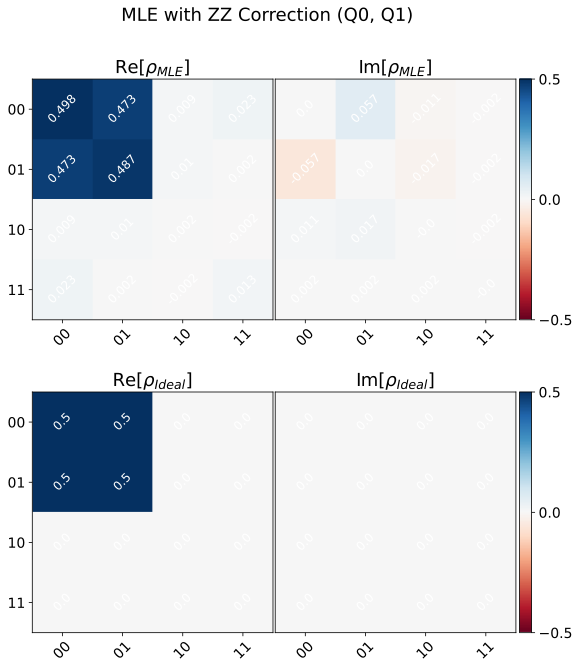





S:\Connie\experiments\qramLL_4QR2\data\data_240617\00118_qram_protocol.h5
S:\Connie\experiments\qramLL_4QR2\data\data_240617\00118_qram_protocol.h5


 C:\Users\slab\AppData\Local\Temp\ipykernel_12272\809401443.py: 13

Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']
init state (Q0 (switch) Q1 (input)): |1>|0+1>


 S:\Connie\experiments\qramLL_4QR2\TomoAnalysis.py: 912ComplexWarning: Casting complex values to real discards the imaginary part
 S:\Connie\experiments\qramLL_4QR2\TomoAnalysis.py: 917

Fidelity (with ZZ correction): 0.9256870466798282
Purity (with ZZ correction): 0.8808765272700402
Target purity: 0.9999999999999996


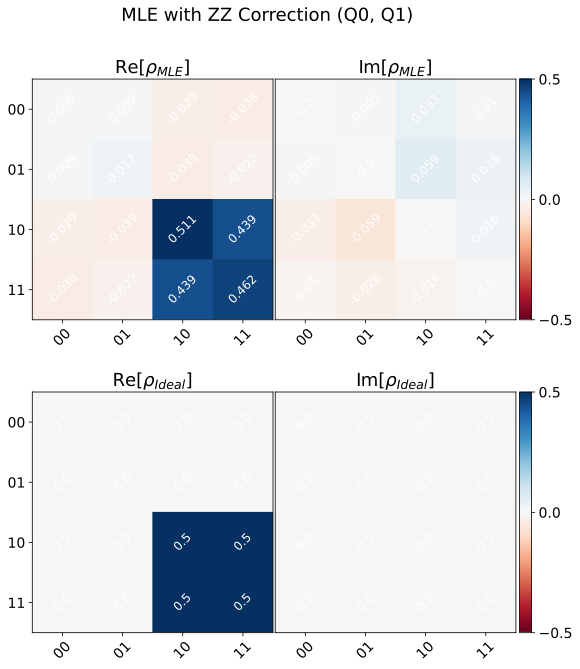





S:\Connie\experiments\qramLL_4QR2\data\data_240617\00119_qram_protocol.h5
S:\Connie\experiments\qramLL_4QR2\data\data_240617\00119_qram_protocol.h5


 C:\Users\slab\AppData\Local\Temp\ipykernel_12272\809401443.py: 13

Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']
init state (Q0 (switch) Q1 (input)): |0+1>|1>


 S:\Connie\experiments\qramLL_4QR2\TomoAnalysis.py: 912ComplexWarning: Casting complex values to real discards the imaginary part
 S:\Connie\experiments\qramLL_4QR2\TomoAnalysis.py: 917

Fidelity (with ZZ correction): 0.9699181906155602
Purity (with ZZ correction): 0.9713284130939508
Target purity: 0.9999999999999996


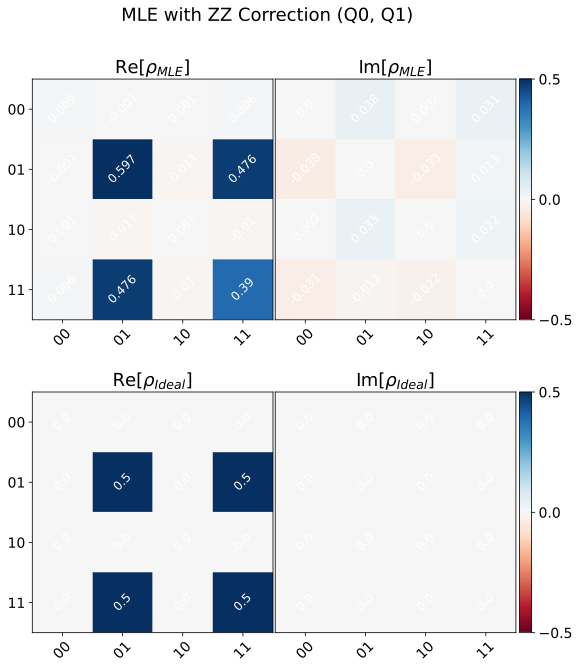





S:\Connie\experiments\qramLL_4QR2\data\data_240617\00120_qram_protocol.h5
S:\Connie\experiments\qramLL_4QR2\data\data_240617\00120_qram_protocol.h5


 C:\Users\slab\AppData\Local\Temp\ipykernel_12272\809401443.py: 13

Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']
init state (Q0 (switch) Q1 (input)): |0+1>|0+1>


 S:\Connie\experiments\qramLL_4QR2\TomoAnalysis.py: 912ComplexWarning: Casting complex values to real discards the imaginary part
 S:\Connie\experiments\qramLL_4QR2\TomoAnalysis.py: 917

Fidelity (with ZZ correction): 0.932289984334396
Purity (with ZZ correction): 0.9520929682806188
Target purity: 0.9999999999999991


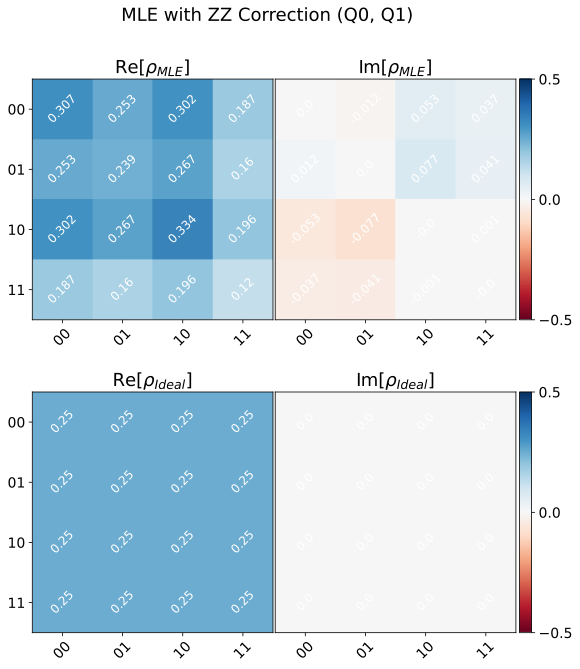





S:\Connie\experiments\qramLL_4QR2\data\data_240617\00121_qram_protocol.h5
S:\Connie\experiments\qramLL_4QR2\data\data_240617\00121_qram_protocol.h5


 C:\Users\slab\AppData\Local\Temp\ipykernel_12272\809401443.py: 13

Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']
init state (Q0 (switch) Q1 (input)): |0>|0>


 S:\Connie\experiments\qramLL_4QR2\TomoAnalysis.py: 912ComplexWarning: Casting complex values to real discards the imaginary part
 S:\Connie\experiments\qramLL_4QR2\TomoAnalysis.py: 917

Fidelity (with ZZ correction): 0.9763337312948668
Purity (with ZZ correction): 0.9620289296327227
Target purity: 1.0


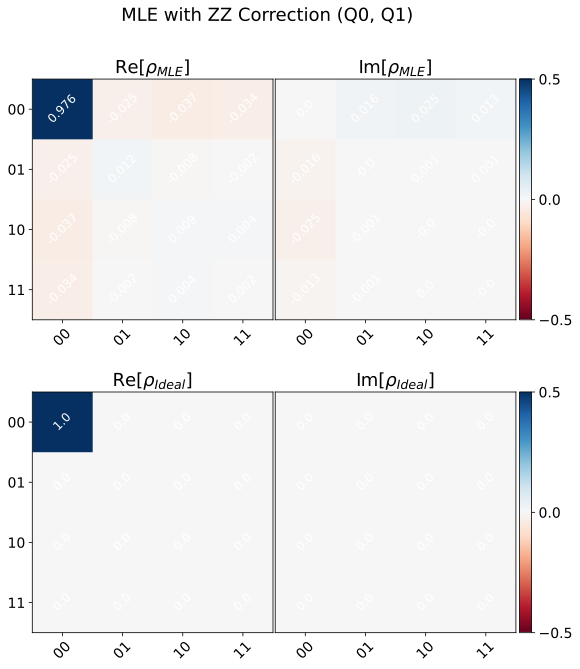





S:\Connie\experiments\qramLL_4QR2\data\data_240617\00122_qram_protocol.h5
S:\Connie\experiments\qramLL_4QR2\data\data_240617\00122_qram_protocol.h5


 C:\Users\slab\AppData\Local\Temp\ipykernel_12272\809401443.py: 13

Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']
init state (Q0 (switch) Q1 (input)): |1>|0>


 S:\Connie\experiments\qramLL_4QR2\TomoAnalysis.py: 912ComplexWarning: Casting complex values to real discards the imaginary part
 S:\Connie\experiments\qramLL_4QR2\TomoAnalysis.py: 917

Fidelity (with ZZ correction): 0.9185029719198231
Purity (with ZZ correction): 0.923833012836263
Target purity: 1.0


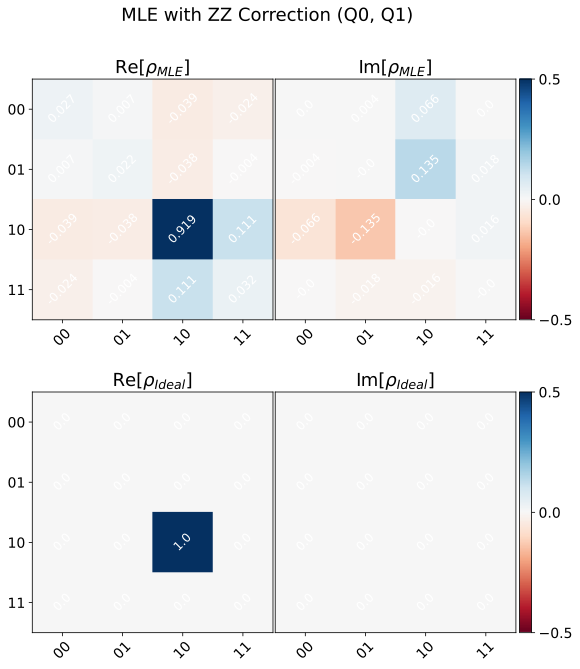





S:\Connie\experiments\qramLL_4QR2\data\data_240617\00123_qram_protocol.h5
S:\Connie\experiments\qramLL_4QR2\data\data_240617\00123_qram_protocol.h5


 C:\Users\slab\AppData\Local\Temp\ipykernel_12272\809401443.py: 13

Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']
init state (Q0 (switch) Q1 (input)): |1>|1>


 S:\Connie\experiments\qramLL_4QR2\TomoAnalysis.py: 912ComplexWarning: Casting complex values to real discards the imaginary part
 S:\Connie\experiments\qramLL_4QR2\TomoAnalysis.py: 917

Fidelity (with ZZ correction): 0.8863156028134213
Purity (with ZZ correction): 0.8882002607741172
Target purity: 1.0


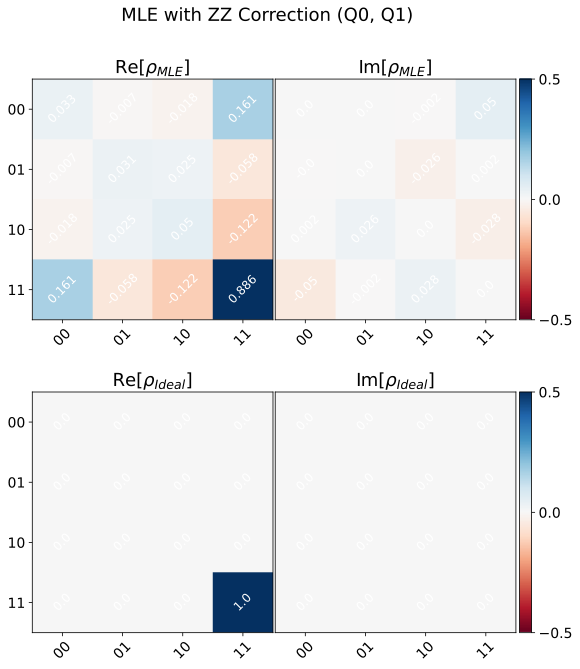





S:\Connie\experiments\qramLL_4QR2\data\data_240617\00124_qram_protocol.h5
S:\Connie\experiments\qramLL_4QR2\data\data_240617\00124_qram_protocol.h5


 C:\Users\slab\AppData\Local\Temp\ipykernel_12272\809401443.py: 13

Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']
init state (Q0 (switch) Q1 (input)): |0>|1>


 S:\Connie\experiments\qramLL_4QR2\TomoAnalysis.py: 912ComplexWarning: Casting complex values to real discards the imaginary part
 S:\Connie\experiments\qramLL_4QR2\TomoAnalysis.py: 917

Fidelity (with ZZ correction): 0.9590728227342517
Purity (with ZZ correction): 0.9372854667220856
Target purity: 1.0


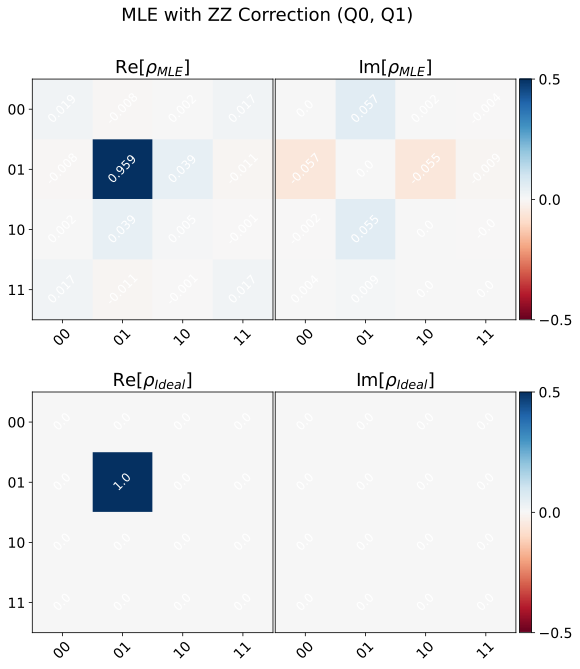

In [564]:
fidelities_ZZ = []
purities_ZZ = []
rho_MLE_ZZ_dict = dict()
init_states = []
for i_saved_file, saved_file in enumerate(saved_files):
    print(saved_file)
    data, attrs = prev_data(saved_file, None)
    cfg = AttrDict(attrs['config'])
    pulse_dict = attrs['pulse_dict']
    
    # print(data.keys())
    # # data = None
    # # style.use('default')
    # # qramExpt.analyze(data=data)
    # # qramExpt.display(data=data, err=False, saveplot=True)
    # # print(data)
    
    init_state = cfg.expt.init_state
    init_states.append(init_state)
    print('init state (Q0 (switch) Q1 (input)):', init_state)
    
    n_tomo_raw, n_calib = tomo_analysis.n_tomo_calib_from_data(data, cfg, ps_adjust=ps_adjust, ps_qubits=ps_qubits, apply_ps=apply_ps, verbose=False)
    
    rho_id = qt.ket2dm(name_to_state_2q(init_state))
    
    rho_MLE_ZZ = tomo_analysis.get_rho_from_counts(
        n_tomo_raw=n_tomo_raw,
        n_calib=n_calib,
        correct_readout=True,
        correct_neg_counts=True,
        method='analytical',
        ZZ_correction=True,
        evol_mats=evol_mats
    )

    
    fid_ZZ = qt.fidelity(qt.Qobj(rho_MLE_ZZ, dims=rho_id.dims), rho_id)**2 # qutip uses N&C fidelity which is "sqrt fidelity"
    purity_ZZ = np.real(np.trace(rho_MLE_ZZ @ rho_MLE_ZZ))
    purity_id = np.real(np.trace(rho_id.full() @ rho_id.full()))
    print(f'Fidelity (with ZZ correction): {fid_ZZ}')
    print(f'Purity (with ZZ correction): {purity_ZZ}')
    print(f'Target purity: {purity_id}')
    
    # savetitle=saved_file[:-3]+'_ZZcorrect.svg'
    savetitle=None
    
    tomo_analysis.show_plot_rho_2d(rho_MLE_ZZ, rho_id, title=f'MLE with ZZ Correction (Q{tomo_qubits[0]}, Q{tomo_qubits[1]})', savetitle=savetitle, cmax=0.5)
    
    fidelities_ZZ.append(fid_ZZ)
    purities_ZZ.append(purity_ZZ)
    rho_MLE_ZZ_dict.update({init_state:rho_MLE_ZZ})
    
    print('\n\n\n')

In [565]:
print('init_states to be saved', rho_MLE_ZZ_dict.keys())
print('ZZ correction fidelities\n', fidelities_ZZ)
print('purities (ZZ correction)\n', purities_ZZ)

# SAVING MEASURED DENSITY MATRICES
from datetime import datetime
timestamp = datetime.now().strftime("%Y%m%d%H%M")
q0, q1 = tomo_qubits
rho_MLE_ZZ_2Q_filepath = os.path.join(expt_path, f'{timestamp}_init_rhoMLE_ZZ_2Q_{q0}{q1}.npz')
np.savez(rho_MLE_ZZ_2Q_filepath, **rho_MLE_ZZ_dict)
print(f'Saved rho_MLE_ZZ for Q{q0} Q{q1} to file {rho_MLE_ZZ_2Q_filepath}')

init_states to be saved dict_keys(['|0+1>|0>', '|0>|0+1>', '|1>|0+1>', '|0+1>|1>', '|0+1>|0+1>', '|0>|0>', '|1>|0>', '|1>|1>', '|0>|1>'])
ZZ correction fidelities
 [0.9660356990651384, 0.9651480722809278, 0.9256870466798282, 0.9699181906155602, 0.932289984334396, 0.9763337312948668, 0.9185029719198231, 0.8863156028134213, 0.9590728227342517]
purities (ZZ correction)
 [0.9382014787279473, 0.9408979288277165, 0.8808765272700402, 0.9713284130939508, 0.9520929682806188, 0.9620289296327227, 0.923833012836263, 0.8882002607741172, 0.9372854667220856]
Saved rho_MLE_ZZ for Q0 Q1 to file S:\Connie\experiments\qramLL_4QR2\data\data_240617\202409250910_init_rhoMLE_ZZ_2Q_01.npz


In [ ]:
# RETREIVE SAVED MEASURED DENSITY MATRICES AND CHECK WHAT EXPECTED QRAM STATE IS
q0, q1 = tomo_qubits
rho_MLE_ZZ_2Q_filepath = 'S:\Connie\experiments\qramLL_4QR2\data\data_240218\\202402281619_init_rhoMLE_ZZ_2Q_01.npz'
print(f'Using rho_MLE_ZZ for Q{q0} Q{q1} from file {rho_MLE_ZZ_2Q_filepath}')

test_rho_MLE_ZZ_dict = dict()
with np.load(rho_MLE_ZZ_2Q_filepath) as npzfile:
    for key in npzfile.keys():
        test_rho_MLE_ZZ_dict.update({key:npzfile[key]})
print(f'rho_MLE_ZZ retrieved with init_states {test_rho_MLE_ZZ_dict.keys()}')

init_state = '|1>|1>'
init_rho = test_rho_MLE_ZZ_dict[init_state]
get_qram_qSLR_state_from_rho(init_rho, output_qubits=[2, 3])

## Run analysis

### Reopen old data

In [698]:
apply_ps = False
ps_adjust = [-0.3, -1.0, -0.3, -0.3]
# ps_adjust = [np.inf]*4
ps_qubits = [0, 1, 2, 3]

In [701]:
filename = 'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00126_qram_protocol.h5'
data, attrs = prev_data(filename, None)
pulse_dict = attrs['pulse_dict']
saved_files = [filename]

print(data.keys())
# # data = None
# # style.use('default')
# # qramExpt.analyze(data=data)
# # qramExpt.display(data=data, err=False, saveplot=True)
# # print(data)

cfg = AttrDict(attrs['config'])
# print(cfg.device.readout)
init_state = cfg.expt.init_state
tomo_qubits = cfg.expt.tomo_qubits
play_pulses = cfg.expt.play_pulses
print('init_state', init_state)
print('tomo_qubits', tomo_qubits)
print('play_pulses', play_pulses)

n_tomo_raw, n_calib = tomo_analysis.n_tomo_calib_from_data(data, cfg, ps_adjust=ps_adjust, ps_qubits=ps_qubits, apply_ps=apply_ps, verbose=True)

print('calib_order', attrs['calib_order'])
print('meas_order', attrs['meas_order'])
print('counts_calib')
n_calib = n_calib.astype(np.float64)
for r in range(n_calib.shape[0]):
    n_calib[r,:]/=np.sum(n_calib[r,:])
print(n_calib)

print('n_tomo_raw')
n_tomo_raw = n_tomo_raw.astype(np.float64)
for r in range(n_tomo_raw.shape[0]):
    n_tomo_raw[r,:]/=np.sum(n_tomo_raw[r,:])
print(n_tomo_raw)

print('n tomo corrected')
print(np.around(tomo_analysis.correct_readout_err(n_tomo_raw, n_calib), decimals=10))

S:\Connie\experiments\qramLL_4QR2\data\data_240617\00126_qram_protocol.h5


 C:\Users\slab\AppData\Local\Temp\ipykernel_12272\809401443.py: 13

Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']
dict_keys(['amps', 'angles', 'avgi', 'avgi_err', 'avgq', 'avgq_err', 'calib_ishots_raw', 'calib_qshots_raw', 'counts_calib', 'counts_tomo', 'ge_avgs', 'ishots_raw', 'phases', 'qshots_raw', 'thresholds', 'xpts'])
init_state |1>|0>
tomo_qubits [0, 1]
play_pulses [0]
calib_order ['gg', 'ge', 'eg', 'ee']
meas_order ['ZZ', 'ZX', 'ZY', 'XZ', 'XX', 'XY', 'YZ', 'YX', 'YY']
counts_calib
[[0.7376     0.17213333 0.0636     0.02666667]
 [0.16283333 0.7556     0.01936667 0.0622    ]
 [0.1465     0.04       0.61056667 0.20293333]
 [0.0492     0.16183333 0.1572     0.63176667]]
n_tomo_raw
[[0.1828     0.04723333 0.5861     0.18386667]
 [0.12       0.09096667 0.4436     0.34543333]
 [0.11756667 0.10186667 0.429      0.35156667]
 [0.444      0.10176667 0.33796667 0.11626667]
 [0.2733     0.27316667 0.24136667 0.21216667]
 [0.26706667 0.27383333 0.24336667 0.21573333]
 [0.42316667 0.1035     0.35446667 0.11886667]
 [0.2540666

### Set ideal rho

Get final qram state from an arbitrary 2Q input density matrix

In [52]:
print('init state Q0 (switch) Q1 (input):', init_state)

init_rho = qt.ket2dm(name_to_state_2q(init_state))
rho_id = init_rho

# print('play_pulses', play_pulses)
# assert (np.all([q in [0, 2, 3] for q in tomo_qubits]) and play_pulses==[2, 1, 4, 3]), 'Automatic ideal rho calculation not available'
# init_rho = init_rho.full()
# rho_id = get_qram_qSLR_state_from_rho(init_rho, output_qubits=tomo_qubits)
rho_id

init state Q0 (switch) Q1 (input): |1>|0+1>


Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.5 0.5]
 [0.  0.  0.5 0.5]]

In [29]:
# rho_id = (qt.ket2dm(psi01) + qt.ket2dm(psi10)).unit()
# rho_id = qt.ket2dm((psi10 + psi11).unit())
# rho_id = qt.ket2dm((psi01 + psi11).unit())
# rho_id = qt.ket2dm((psi00 + psi10).unit())
# rho_id = qt.ket2dm((psi00 + psi01 + psi10 + psi11).unit())
# rho_id = qt.ket2dm((psi00+psi01).unit())
rho_id = qt.ket2dm((psi10).unit())

### Generate test data

In [ ]:
rho_id = qt.ket2dm(psi10 + psi11).unit()

# n_tomo_raw = generate_counts(rho_id=rho_id, n_tot=8000, noise=None)
n_tomo_raw = tomo_analysis.generate_counts(rho_id=rho_id, n_tot=20000, evol_mats=evol_mats, noise=None)
# n_calib = qt.qeye(4).full()
# print(fix_neg_counts(n_tomo_raw))

# n_tomo_raw = generate_counts(rho_id=rho_id, n_tot=8000, noise=None)
# print(fix_neg_counts(n_tomo_raw))

# n_tomo_raw = [[2000, 2000, 2000, 2000.] ,
#  [2001, 1999, 3411,  589.] ,
#  [4005,    0, 3398,  602.] ,
#  [4010, 2179,    0, 1822.] ,
#  [4068, 2127,  802, 1019.] ,
#  [5895,  302,  806, 1016.] ,
#  [2008,  191, 1992, 3808.] ,
#  [ 649, 1552, 3754, 2043.] ,
#  [1523,  678,  233, 5564.]]

# n_tomo_raw = [[   0,    0, 4000, 4000.],
#  [   0,    0, 6796, 1204.],
#  [   0,    0, 1179, 6821.],
#  [2004, 1167, 1996, 2833.],
#  [2048, 1126,  180, 4646.],
#  [ 127, 3046, 3258, 1568.],
#  [2005, 1167, 1995, 2833.],
#  [2048, 1127,  180, 4646.],
#  [ 127, 3046, 3258, 1568.],]

# n_tomo_raw= [[2000, 2000., 2000., 2000.],
#  [2001, 1999., 2000., 2000.],
#  [4005,    0., 4000.,    0.],
#  [4010, 4002.,    0.,    0.],
#  [4012, 4005.,    0.,    0.],
#  [8021,    0.,    0.,    0.],
#  [2008, 2002., 1992., 1998.],
#  [2008, 2005., 1996., 1991.],
#  [4015,    0., 3987.,    0.],]


# n_tomo_raw = np.array(
#     [[4978, 5022,    0,    0.],
#      [4807, 5193,    0,    0.],
#      [5002, 4998,    0,    0.],
#      [3880, 4899, 1221,    0.],
#      [4802, 4279,  919,    0.],
#      [5028, 4187,  727,   57.],
#      [4068, 5093,  839,    0.],
#      [4688, 4689,  622,    0.],
#      [4927, 4741,  332,    0.]]
# )

print(n_tomo_raw)

### Run MLE without ZZ correction

Fidelity (no ZZ correction): 0.9000040673477412
Purity (no ZZ correction): 0.8356613985486175
[[ 0.082-0.j     0.018-0.016j  0.029-0.066j  0.001-0.023j]
 [ 0.018+0.016j  0.007-0.j     0.037-0.004j  0.003-0.004j]
 [ 0.029+0.066j  0.037+0.004j  0.9  -0.j    -0.031+0.027j]
 [ 0.001+0.023j  0.003+0.004j -0.031-0.027j  0.011-0.j   ]]


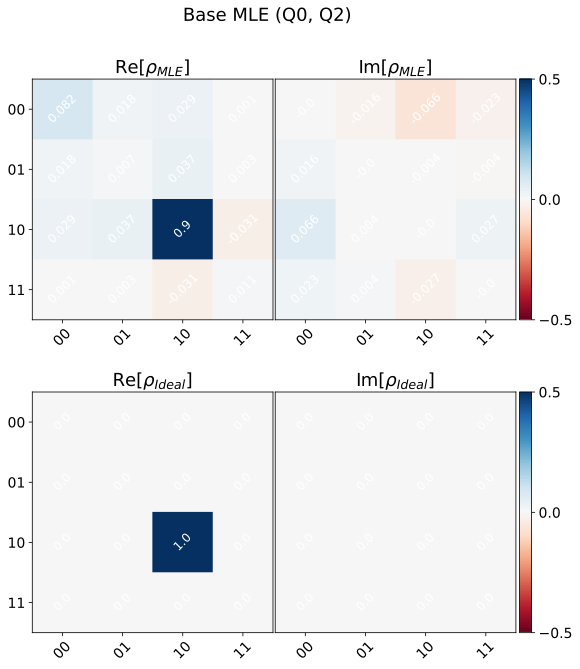

In [66]:
rho_MLE_base = tomo_analysis.get_rho_from_counts(
    n_tomo_raw=n_tomo_raw,
    n_calib=n_calib,
    correct_readout=True,
    correct_neg_counts=True,
    method='analytical',
    ZZ_correction=False,
    evol_mats=evol_mats
)

fid_base = qt.fidelity(qt.Qobj(rho_MLE_base, dims=id2q.dims), rho_id)**2 # qutip uses N&C fidelity which is "sqrt fidelity"
purity_base = np.real(np.trace(rho_MLE_base @ rho_MLE_base))
print(f'Fidelity (no ZZ correction): {fid_base}')
print(f'Purity (no ZZ correction): {purity_base}')
print(np.around(rho_MLE_base, decimals=3))
tomo_analysis.show_plot_rho_2d(rho_MLE_base, rho_id, title=f'Base MLE (Q{tomo_qubits[0]}, Q{tomo_qubits[1]})', cmax=0.5)

### Run MLE with ZZ

Get evol mats for ZZ

In [646]:
# Recover old config
yaml_cfg = AttrDict(attrs['config'])

In [68]:
import yaml
with open(config_path, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

In [69]:
# evol_mats_path = os.path.join(os.getcwd(), 'evol_mats')
evol_mats_path = "S:\\QRAM\\qram_4QR2\\evol_mats"
print('Will save evol mats to path', evol_mats_path)

q0, q1 = tomo_qubits
# evol_mats_filename = f'evol_mats_{q0}{q1}_test.npz'
evol_mats_filename = f'evol_mats_{q0}{q1}.npz'

# evol_mats_filename += '_test'
print('Will save to filename', evol_mats_filename)

Will save evol mats to path S:\QRAM\qram_4QR2\evol_mats
Will save to filename evol_mats_02.npz


TOMO QUBITS [0, 2]
WARNING USING NEGATIVE ZZ!
qubit freqs (MHz) [4110.85058605 4762.20157232]
ZZs (MHz) [[ 0.         -0.13169829]
 [-0.13169829  0.        ]]
ZZ average (GHz) -0.00013169829472235505
Will save to filename evol_mats_02.npz


  0%|          | 0/9 [00:00<?, ?it/s]

ZZ
truncating to states inds [0, 1, 3, 4]
evolution ket result
Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 1), type = oper, isherm = False
Qobj data =
[[1.]
 [0.]
 [0.]
 [0.]]
truncating to states inds [0, 1, 3, 4]
evolution ket result
Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 1), type = oper, isherm = False
Qobj data =
[[0.]
 [1.]
 [0.]
 [0.]]
truncating to states inds [0, 1, 3, 4]
evolution ket result
Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 1), type = oper, isherm = False
Qobj data =
[[0.]
 [0.]
 [1.]
 [0.]]
truncating to states inds [0, 1, 3, 4]
evolution ket result
Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 1), type = oper, isherm = False
Qobj data =
[[0.]
 [0.]
 [0.]
 [1.]]

ZX
add pi pulse on qubit 2 with freq 4762.201572322125 length 5.3117997384806745 amp 0.018864472342645527


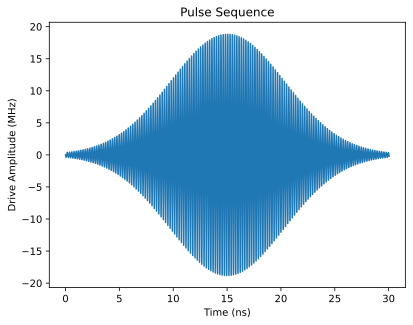

truncating to states inds [0, 1, 3, 4]
evolution ket result
Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 1), type = oper, isherm = False
Qobj data =
[[ 0.70840055+0.006666j  ]
 [-0.70551671+0.01924515j]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]]
from gg
gg probabilty 0.5018754157851545
ge probabilty 0.4981238541322162
eg probabilty 0.0
ee probabilty 0.0


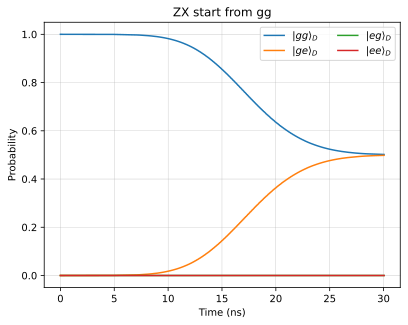

truncating to states inds [0, 1, 3, 4]
evolution ket result
Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 1), type = oper, isherm = False
Qobj data =
[[0.70619756-0.01927506j]
 [0.70630216-0.04528505j]
 [0.        +0.j        ]
 [0.        +0.j        ]]
from ge
gg probabilty 0.4990845200311156
ge probabilty 0.5009114663806488
eg probabilty 0.0
ee probabilty 0.0


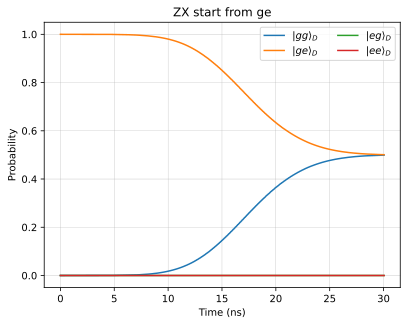

truncating to states inds [0, 1, 3, 4]
evolution ket result
Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 1), type = oper, isherm = False
Qobj data =
[[ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [ 0.70820709+0.00537302j]
 [-0.70590836+0.01035451j]]
from eg
gg probabilty 0.0
ge probabilty 0.0
eg probabilty 0.5015857950345222
ee probabilty 0.49841347450339274


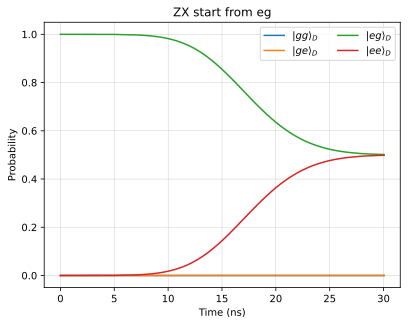

truncating to states inds [0, 1, 3, 4]
evolution ket result
Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 1), type = oper, isherm = False
Qobj data =
[[0.        +0.j        ]
 [0.        +0.j        ]
 [0.70631629-0.01042969j]
 [0.70733372-0.02622058j]]
from ee
gg probabilty 0.0
ge probabilty 0.0
eg probabilty 0.4989894919132842
ee probabilty 0.5010065102252373


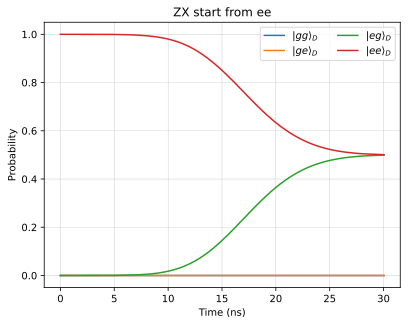


ZY
add pi pulse on qubit 2 with freq 4762.201572322125 length 5.3117997384806745 amp 0.018864472342645527


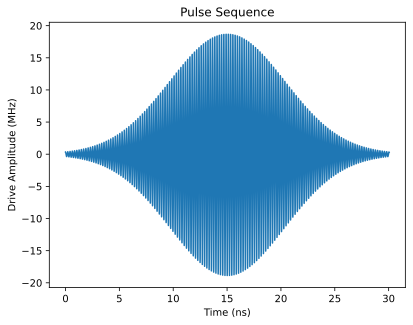

truncating to states inds [0, 1, 3, 4]
evolution ket result
Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 1), type = oper, isherm = False
Qobj data =
[[ 0.70837616+0.00663152j]
 [-0.01922915-0.70554197j]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]]
from gg
gg probabilty 0.5018404237661133
ge probabilty 0.49815889165971367
eg probabilty 0.0
ee probabilty 0.0


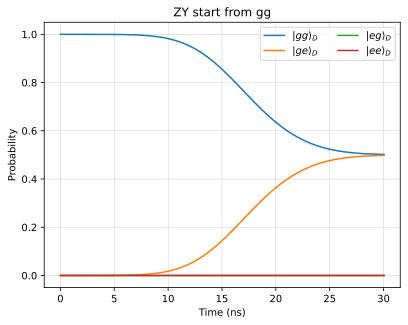

truncating to states inds [0, 1, 3, 4]
evolution ket result
Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 1), type = oper, isherm = False
Qobj data =
[[-0.01929235-0.70622197j]
 [ 0.70627961-0.04524852j]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]]
from ge
gg probabilty 0.4991198162090913
ge probabilty 0.5008764646753747
eg probabilty 0.0
ee probabilty 0.0


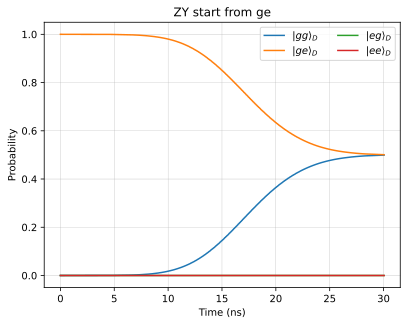

truncating to states inds [0, 1, 3, 4]
evolution ket result
Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 1), type = oper, isherm = False
Qobj data =
[[ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [ 0.70818322+0.0053377j ]
 [-0.01033873-0.70593281j]]
from eg
gg probabilty 0.0
ge probabilty 0.0
eg probabilty 0.5015516315233579
ee probabilty 0.49844768403297535


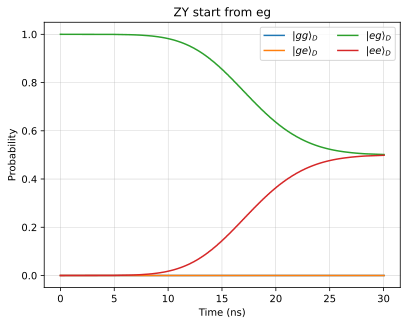

truncating to states inds [0, 1, 3, 4]
evolution ket result
Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 1), type = oper, isherm = False
Qobj data =
[[ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [-0.01044647-0.70634011j]
 [ 0.70731101-0.02618485j]]
from ee
gg probabilty 0.0
ge probabilty 0.0
eg probabilty 0.49902363512396136
ee probabilty 0.5009726608312717


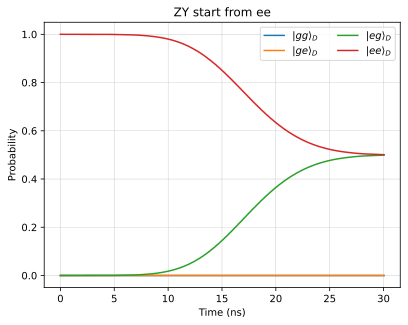


XZ
add pi pulse on qubit 0 with freq 4110.8505860455725 length 7.082399651307567 amp 0.014148354256984144


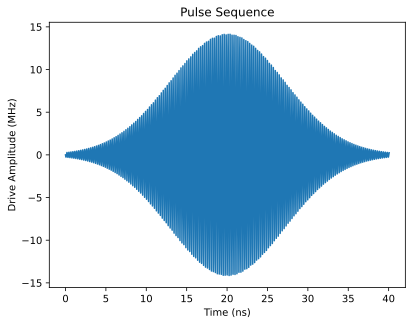

truncating to states inds [0, 1, 3, 4]
evolution ket result
Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 1), type = oper, isherm = False
Qobj data =
[[ 0.70800231+0.00425867j]
 [ 0.        +0.j        ]
 [-0.70609908+0.01177459j]
 [ 0.        +0.j        ]]
from gg
gg probabilty 0.5012852815976683
ge probabilty 0.0
eg probabilty 0.4987144208422444
ee probabilty 0.0


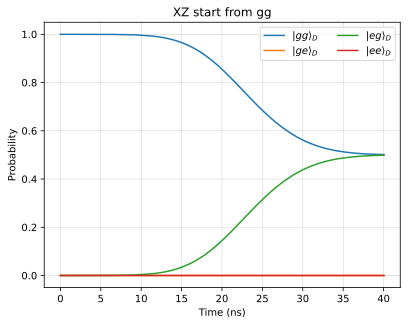

truncating to states inds [0, 1, 3, 4]
evolution ket result
Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 1), type = oper, isherm = False
Qobj data =
[[ 0.        +0.00000000e+00j]
 [ 0.70762246+2.60722536e-03j]
 [ 0.        +0.00000000e+00j]
 [-0.70658589-9.40838325e-05j]]
from ge
gg probabilty 0.0
ge probabilty 0.500736210177251
eg probabilty 0.0
ee probabilty 0.4992634921226331


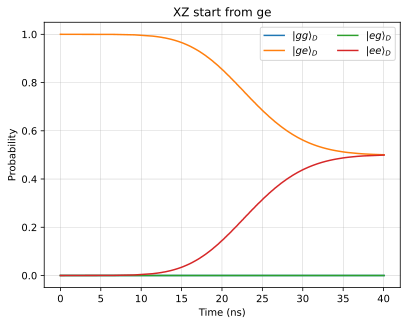

truncating to states inds [0, 1, 3, 4]
evolution ket result
Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 1), type = oper, isherm = False
Qobj data =
[[0.7071017 -0.01180665j]
 [0.        +0.j        ]
 [0.70646271-0.02789595j]
 [0.        +0.j        ]]
from eg
gg probabilty 0.5001321944162074
ge probabilty 0.0
eg probabilty 0.4998677366644606
ee probabilty 0.0


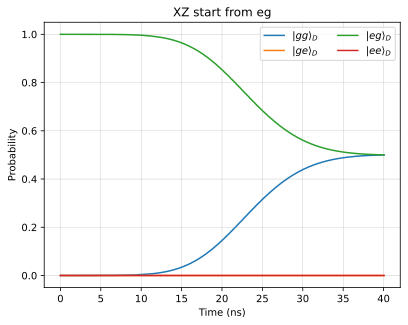

truncating to states inds [0, 1, 3, 4]
evolution ket result
Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 1), type = oper, isherm = False
Qobj data =
[[0.        +0.00000000e+00j]
 [0.70695193+2.86071031e-06j]
 [0.        +0.00000000e+00j]
 [0.70725705-2.53428810e-03j]]
from ee
gg probabilty 0.0
ge probabilty 0.49978100552211585
eg probabilty 0.0
ee probabilty 0.5002189246172116


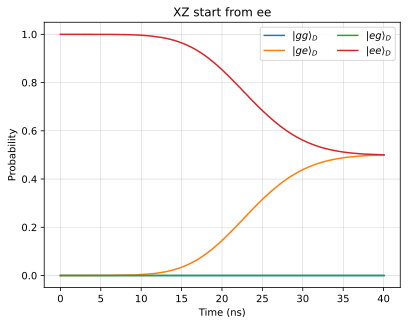


XX
add pi pulse on qubit 0 with freq 4110.8505860455725 length 7.082399651307567 amp 0.014148354256984144
add pi pulse on qubit 2 with freq 4762.201572322125 length 5.3117997384806745 amp 0.018864472342645527


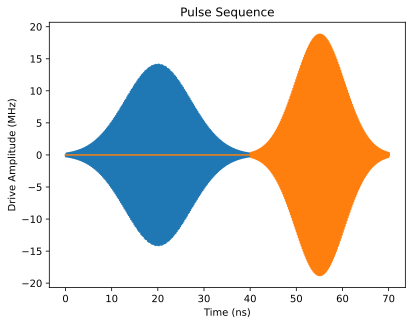

truncating to states inds [0, 1, 3, 4]
evolution ket result
Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 1), type = oper, isherm = False
Qobj data =
[[ 0.50159229+0.00773137j]
 [-0.49997026+0.01069192j]
 [-0.49986637+0.00455355j]
 [ 0.49812708-0.01559117j]]
from gg
gg probabilty 0.2516543539760681
ge probabilty 0.2500843358006106
eg probabilty 0.24988688055495697
ee probabilty 0.24837343309023263


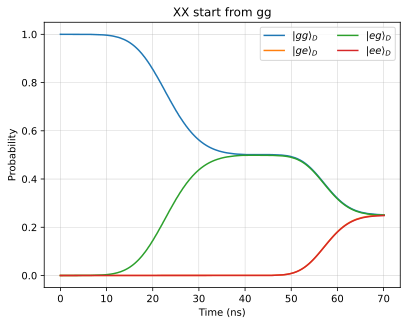

truncating to states inds [0, 1, 3, 4]
evolution ket result
Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 1), type = oper, isherm = False
Qobj data =
[[ 0.49982075-0.01187731j]
 [ 0.50019178-0.03033295j]
 [-0.4988972 +0.00731346j]
 [-0.49963435+0.01843362j]]
from ge
gg probabilty 0.24996084859224615
ge probabilty 0.2511108903936104
eg probabilty 0.2489509029874861
ee probabilty 0.24997327714394704


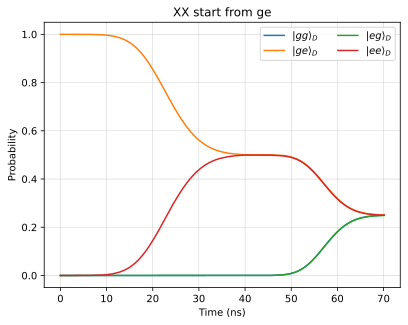

truncating to states inds [0, 1, 3, 4]
evolution ket result
Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 1), type = oper, isherm = False
Qobj data =
[[ 0.5010609 -0.00365693j]
 [-0.49902323+0.02201739j]
 [ 0.50021113-0.01596155j]
 [-0.49821914+0.02696923j]]
from eg
gg probabilty 0.2510752235799632
ge probabilty 0.24950876934325422
eg probabilty 0.25046576873864834
ee probabilty 0.24894947047026392


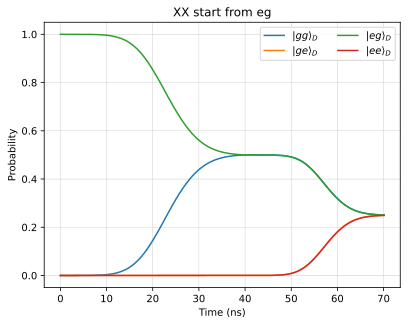

truncating to states inds [0, 1, 3, 4]
evolution ket result
Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 1), type = oper, isherm = False
Qobj data =
[[0.49929674-0.01370356j]
 [0.4995994 -0.03214278j]
 [0.49934411-0.00917595j]
 [0.50004101-0.02030929j]]
from ee
gg probabilty 0.2494840722039151
ge probabilty 0.2506317618917413
eg probabilty 0.2494277915293246
ee probabilty 0.250452521758844


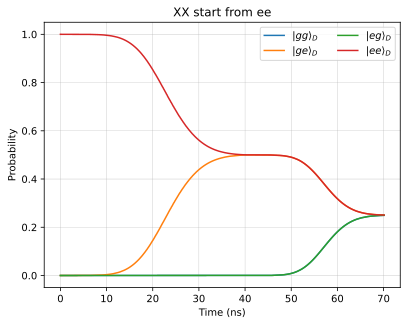


XY
add pi pulse on qubit 0 with freq 4110.8505860455725 length 7.082399651307567 amp 0.014148354256984144
add pi pulse on qubit 2 with freq 4762.201572322125 length 5.3117997384806745 amp 0.018864472342645527


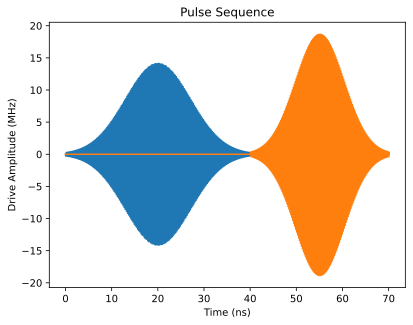

truncating to states inds [0, 1, 3, 4]
evolution ket result
Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 1), type = oper, isherm = False
Qobj data =
[[ 0.50160094+0.00774394j]
 [-0.01071084-0.4999609j ]
 [-0.49987516+0.00454127j]
 [ 0.01560975+0.49811784j]]
from gg
gg probabilty 0.25166322747317393
ge probabilty 0.2500753868331524
eg probabilty 0.24989556268262703
ee probabilty 0.24836480877786532


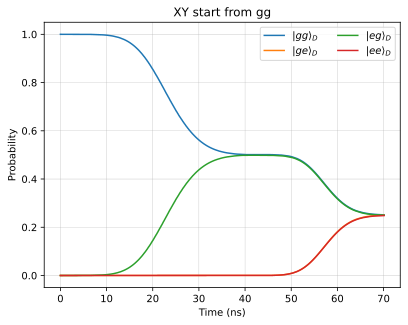

truncating to states inds [0, 1, 3, 4]
evolution ket result
Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 1), type = oper, isherm = False
Qobj data =
[[-0.01185767-0.49981291j]
 [ 0.50020042-0.03034568j]
 [ 0.00729363+0.49888843j]
 [-0.49964186+0.01844552j]]
from ge
gg probabilty 0.24995250264185084
ge probabilty 0.25112026388367475
eg probabilty 0.24894181763375275
ee probabilty 0.2499811806436698


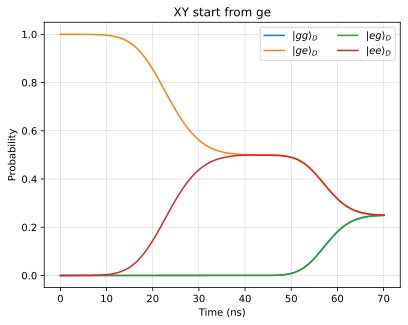

truncating to states inds [0, 1, 3, 4]
evolution ket result
Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 1), type = oper, isherm = False
Qobj data =
[[ 0.50106953-0.00364456j]
 [-0.02203612-0.49901309j]
 [ 0.50022058-0.01595014j]
 [-0.02698837-0.49820974j]]
from eg
gg probabilty 0.25108377416372873
ge probabilty 0.24949946479938717
eg probabilty 0.2504748477094543
ee probabilty 0.24894112788514522


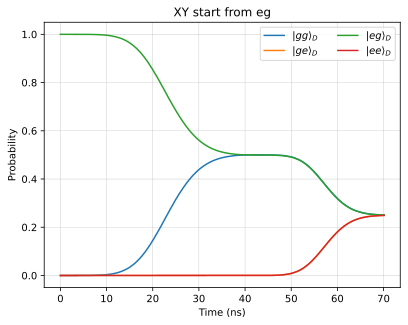

truncating to states inds [0, 1, 3, 4]
evolution ket result
Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 1), type = oper, isherm = False
Qobj data =
[[-0.01368393-0.49928899j]
 [ 0.49960797-0.03215553j]
 [-0.00915608-0.49933541j]
 [ 0.50004846-0.02032123j]]
from ee
gg probabilty 0.24947576248415962
ge probabilty 0.25064111072682504
eg probabilty 0.24941870121328688
ee probabilty 0.2504604188225123


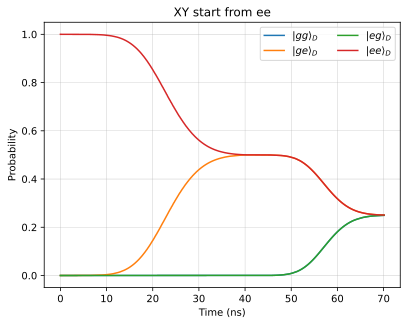


YZ
add pi pulse on qubit 0 with freq 4110.8505860455725 length 7.082399651307567 amp 0.014148354256984144


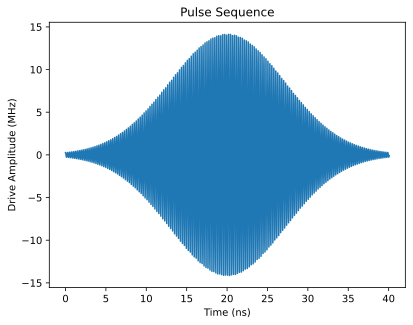

truncating to states inds [0, 1, 3, 4]
evolution ket result
Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 1), type = oper, isherm = False
Qobj data =
[[ 0.70798874+0.00425416j]
 [ 0.        +0.j        ]
 [-0.01173506-0.70611338j]
 [ 0.        +0.j        ]]
from gg
gg probabilty 0.501266004751413
ge probabilty 0.0
eg probabilty 0.49873367684177144
ee probabilty 0.0


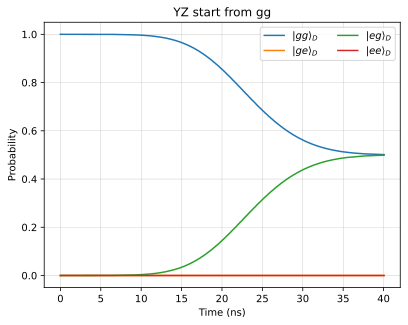

truncating to states inds [0, 1, 3, 4]
evolution ket result
Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 1), type = oper, isherm = False
Qobj data =
[[0.00000000e+00+0.j        ]
 [7.07608742e-01+0.00260233j]
 [0.00000000e+00+0.j        ]
 [1.33835203e-04-0.70659963j]]
from ge
gg probabilty 0.0
ge probabilty 0.5007167622798715
eg probabilty 0.0
ee probabilty 0.49928291916596024


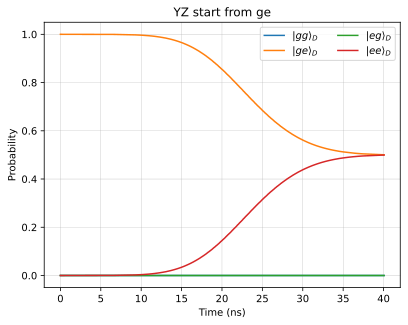

truncating to states inds [0, 1, 3, 4]
evolution ket result
Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 1), type = oper, isherm = False
Qobj data =
[[-0.01184664-0.70711475j]
 [ 0.        +0.j        ]
 [ 0.70644924-0.02789013j]
 [ 0.        +0.j        ]]
from eg
gg probabilty 0.5001515950865607
ge probabilty 0.0
eg probabilty 0.49984836545330696
ee probabilty 0.0


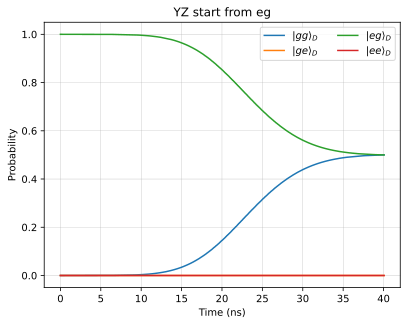

truncating to states inds [0, 1, 3, 4]
evolution ket result
Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 1), type = oper, isherm = False
Qobj data =
[[ 0.00000000e+00+0.j        ]
 [-3.68621154e-05-0.7069655j ]
 [ 0.00000000e+00+0.j        ]
 [ 7.07243503e-01-0.00252929j]]
from ee
gg probabilty 0.0
ge probabilty 0.499800204697031
eg probabilty 0.0
ee probabilty 0.5001997545178685


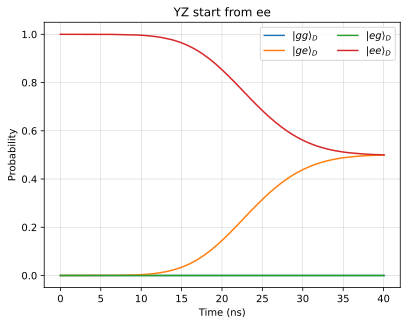


YX
add pi pulse on qubit 0 with freq 4110.8505860455725 length 7.082399651307567 amp 0.014148354256984144
add pi pulse on qubit 2 with freq 4762.201572322125 length 5.3117997384806745 amp 0.018864472342645527


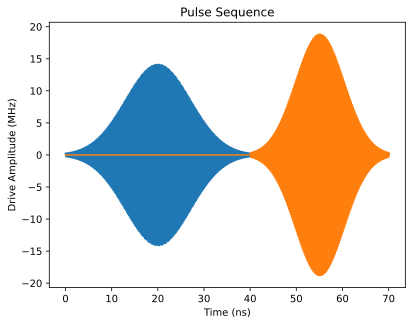

truncating to states inds [0, 1, 3, 4]
evolution ket result
Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 1), type = oper, isherm = False
Qobj data =
[[ 0.50158264+0.00772813j]
 [-0.49996072+0.01069477j]
 [-0.00452555-0.4998762j ]
 [ 0.01556346+0.49813761j]]
from gg
gg probabilty 0.25164462199185894
ge probabilty 0.250074853329224
eg probabilty 0.2498964482738664
ee probabilty 0.2483830588510831


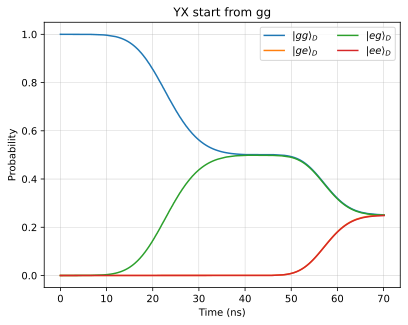

truncating to states inds [0, 1, 3, 4]
evolution ket result
Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 1), type = oper, isherm = False
Qobj data =
[[ 0.49981103-0.01188047j]
 [ 0.50018196-0.03033578j]
 [-0.0072855 -0.49890728j]
 [-0.01840585-0.49964505j]]
from ge
gg probabilty 0.24995119879157185
ge probabilty 0.25110122692652703
eg probabilty 0.24896054209049287
ee probabilty 0.2499829302024232


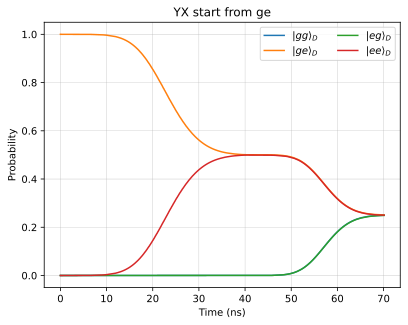

truncating to states inds [0, 1, 3, 4]
evolution ket result
Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 1), type = oper, isherm = False
Qobj data =
[[-0.00368518-0.50107038j]
 [ 0.0220459 +0.49903145j]
 [ 0.50020169-0.01595731j]
 [-0.49820976+0.02696479j]]
from eg
gg probabilty 0.2510849321104159
ge probabilty 0.2495182407729249
eg probabilty 0.2504561967693846
ee probabilty 0.24893989195708918


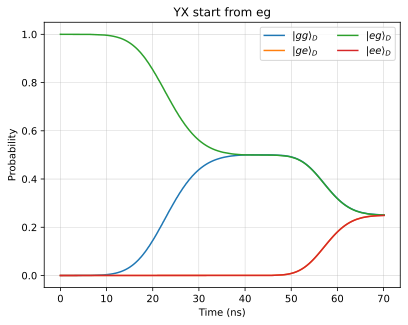

truncating to states inds [0, 1, 3, 4]
evolution ket result
Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 1), type = oper, isherm = False
Qobj data =
[[-0.01373189-0.49930539j]
 [-0.03217147-0.499607j  ]
 [ 0.49933472-0.00917226j]
 [ 0.50003175-0.02030537j]]
from ee
gg probabilty 0.2494934985212507
ge probabilty 0.25064121780232423
eg probabilty 0.24941834891409065
ee probabilty 0.25044311130089864


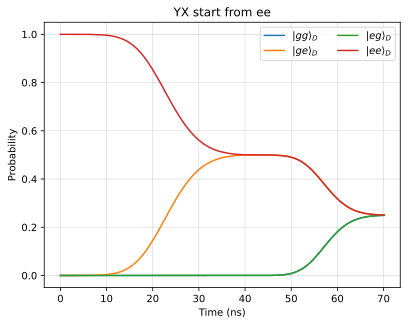


YY
add pi pulse on qubit 0 with freq 4110.8505860455725 length 7.082399651307567 amp 0.014148354256984144
add pi pulse on qubit 2 with freq 4762.201572322125 length 5.3117997384806745 amp 0.018864472342645527


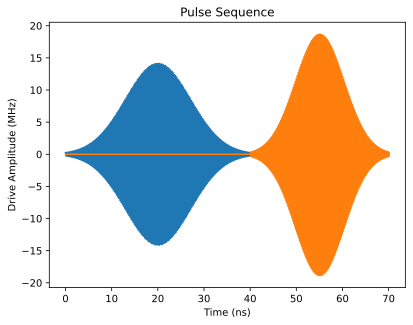

truncating to states inds [0, 1, 3, 4]
evolution ket result
Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 1), type = oper, isherm = False
Qobj data =
[[ 0.50159116+0.00774073j]
 [-0.01071362-0.49995105j]
 [-0.00451387-0.49988532j]
 [-0.4981285 +0.01558262j]]
from gg
gg probabilty 0.251653358900551
ge probabilty 0.2500655798652727
eg probabilty 0.24990545678952583
ee probabilty 0.2483745691377227


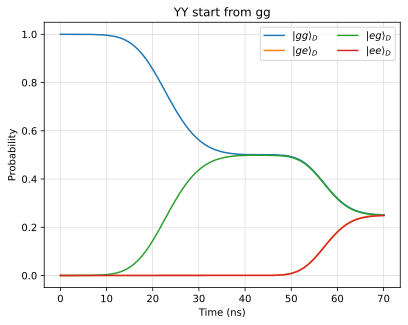

truncating to states inds [0, 1, 3, 4]
evolution ket result
Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 1), type = oper, isherm = False
Qobj data =
[[-0.01186097-0.49980319j]
 [ 0.50019058-0.0303486j ]
 [-0.49889849+0.00726651j]
 [-0.01841856-0.49965252j]]
from ge
gg probabilty 0.24994285913571057
ge probabilty 0.2511106008047075
eg probabilty 0.24895145543376615
ee probabilty 0.24999082847414333


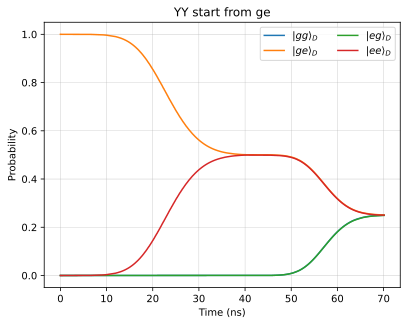

truncating to states inds [0, 1, 3, 4]
evolution ket result
Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 1), type = oper, isherm = False
Qobj data =
[[-0.00367297-0.50107913j]
 [-0.49902154+0.02206457j]
 [ 0.50021091-0.01594604j]
 [-0.02698385-0.49820024j]]
from eg
gg probabilty 0.25109360392359314
ge probabilty 0.24950916314894844
eg probabilty 0.25046504897681215
ee probabilty 0.2489314280046007


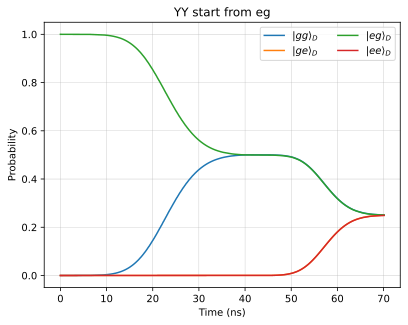

truncating to states inds [0, 1, 3, 4]
evolution ket result
Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 1), type = oper, isherm = False
Qobj data =
[[-0.49929765+0.0137124j ]
 [-0.03218432-0.49961557j]
 [-0.00915325-0.49932601j]
 [ 0.50003916-0.02031814j]]
from ee
gg probabilty 0.24948519084735848
ge probabilty 0.25065056204109865
eg probabilty 0.24940926437004643
ee probabilty 0.25045100530346737


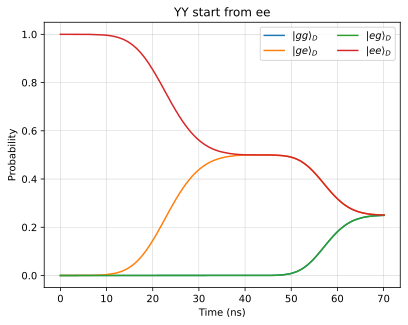


Saved evol mats to file S:\QRAM\qram_4QR2\evol_mats\evol_mats_02.npz


In [70]:
f_ge = np.array([f + (4000 if f < 1000 else 0) for f in np.reshape(yaml_cfg.device.qubit.f_ge, (4,4)).diagonal()]) # MHz
f_ef = np.array([f + (4000 if f < 1000 else 0) for f in np.reshape(yaml_cfg.device.qubit.f_ef, (4,4)).diagonal()]) # Mhz

# f_ge = np.array([f + (4000 if f < 1000 else 0) for f in yaml_cfg.device.qubit.f_ge]) # MHz
# f_ef = np.array([f + (4000 if f < 1000 else 0) for f in yaml_cfg.device.qubit.f_ef]) # Mhz

q0, q1 = tomo_qubits
print('TOMO QUBITS', tomo_qubits)

ZZs_4q = np.zeros((4,4))
reshaped_f_ge = np.reshape(yaml_cfg.device.qubit.f_ge, (4,4))
for row in range(4):
    ZZs_4q[row,:] = reshaped_f_ge[row,:] - reshaped_f_ge[row,row]
    
f_ge = np.array([f_ge[q0], f_ge[q1]])
f_ef = np.array([f_ef[q0], f_ef[q1]])
alphas = f_ef - f_ge # MHz
ZZs = np.array([[0., 0.], [0., 0.]])
# ZZs = np.array([[100., 100.], [100., 100.]])
ZZs[0, 1] = ZZs_4q[q0, q1]
ZZs[1, 0] = ZZs_4q[q1, q0]
ZZs = (ZZs + ZZs.transpose())/2

# # f_ge = np.array([4000, 4500])
# ZZs[0, 1] = -6.0
# ZZs[1, 0] = -6.0
# print('WARNING USING NEGATIVE ZZ!')
# ZZs = -1*ZZs

print('qubit freqs (MHz)', f_ge)
# print('alphas', alphas)
print('ZZs (MHz)', ZZs)
print('ZZ average (GHz)', 1e-3*np.average([ZZs[0,1], ZZs[1,0]]))
# print(pulse_dict)

print('Will save to filename', evol_mats_filename)

evol_mats = tomo_analysis.get_evol_mats(qubits=tomo_qubits, cutoffs=[3, 3], qfreqs=f_ge*1e-3, alphas=alphas*1e-3, ZZs=ZZs*1e-3, pulse_dict=pulse_dict, soccfg=soc, debug=True)
# evol_mats = get_evol_mats(qubits=qubits, qfreqs=f_ge*1e-3, alphas=alphas*1e-3, gs=gs*1e-3, pulse_dict=pulse_dict)

# print(evol_mats)
evol_mats_file_path = os.path.join(evol_mats_path, evol_mats_filename)
np.savez(evol_mats_file_path, **evol_mats)
print(f'Saved evol mats to file {evol_mats_file_path}')

Reload evol mats

In [71]:
q0, q1 = tomo_qubits
evol_mats_file_path = os.path.join(evol_mats_path, evol_mats_filename)
print(f'Using evol mats from file {evol_mats_file_path}')

evol_mats = dict()
with np.load(evol_mats_file_path) as npzfile:
    for key in npzfile.keys():
        evol_mats.update({key:npzfile[key]})
# print(evol_mats)

Using evol mats from file S:\QRAM\qram_4QR2\evol_mats\evol_mats_02.npz


#### (Actually) run MLE with ZZ correction

init state |1>|0>


 S:\Connie\experiments\qram_tprocv1_expts\TomoAnalysis.py: 938ComplexWarning: Casting complex values to real discards the imaginary part
 S:\Connie\experiments\qram_tprocv1_expts\TomoAnalysis.py: 943

[[ 0.007+0.j    -0.001+0.003j -0.043-0.012j -0.002+0.003j]
 [-0.001-0.003j  0.003+0.j    -0.014+0.002j  0.002-0.j   ]
 [-0.043+0.012j -0.014-0.002j  0.988-0.j     0.006-0.007j]
 [-0.002-0.003j  0.002+0.j     0.006+0.007j  0.002+0.j   ]]
list format [[(0.007+0j), (-0.001+0.003j), (-0.043-0.012j), (-0.002+0.003j)], [(-0.001-0.003j), (0.003+0j), (-0.014+0.002j), (0.002-0j)], [(-0.043+0.012j), (-0.014-0.002j), (0.988-0j), (0.006-0.007j)], [(-0.002-0.003j), (0.002+0j), (0.006+0.007j), (0.002+0j)]]
Fidelity (with ZZ correction): 0.9878210776393579
Purity (with ZZ correction): 0.9804761051915283
Target purity: 1.0


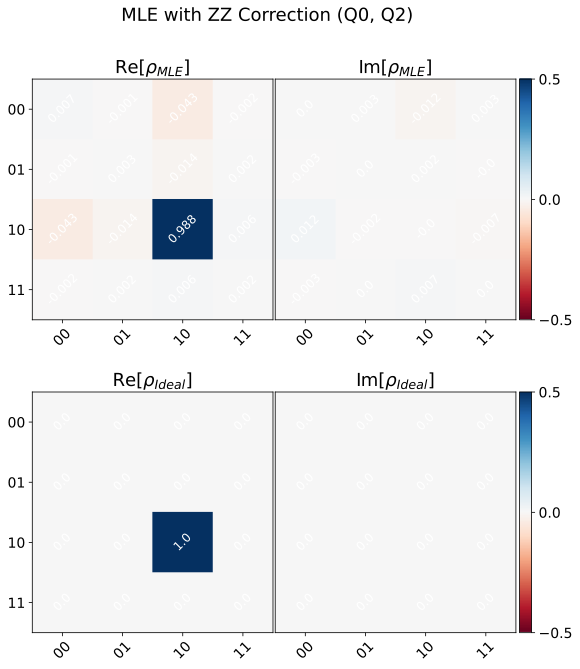

Saved svg: None
Saved data:
S:\QRAM\qram_4QR2\data\data_240617\00140_qram_protocol.h5


In [95]:
print('init state', init_state)
# print('post selection', postselect)
# if postselect: print('post select state', postselect_state)

rho_MLE_ZZ = tomo_analysis.get_rho_from_counts(
    n_tomo_raw=n_tomo_raw,
    n_calib=n_calib,
    correct_readout=True,
    correct_neg_counts=True,
    method='analytical',
    ZZ_correction=True,
    evol_mats=evol_mats
)

print(np.around(rho_MLE_ZZ, decimals=3))
print('list format', np.around(rho_MLE_ZZ, decimals=3).tolist())
fid_ZZ = qt.fidelity(qt.Qobj(rho_MLE_ZZ, dims=rho_id.dims), rho_id)**2 # qutip uses N&C fidelity which is "sqrt fidelity"
purity_ZZ = np.real(np.trace(rho_MLE_ZZ @ rho_MLE_ZZ))
purity_id = np.real(np.trace(rho_id.full() @ rho_id.full()))
print(f'Fidelity (with ZZ correction): {fid_ZZ}')
print(f'Purity (with ZZ correction): {purity_ZZ}')
print(f'Target purity: {purity_id}')
# savetitle = '1_0+1_ideal.png'
# savetitle = 'test.png'
savetitle=None
plt.style.use('default')
# show_plot_rho_2d(rho_id, rho_id, title='MLE with ZZ Correction', savetitle=savetitle) #, cmax=1.0)
# savetitle=saved_files[-1][:-3]+'_ZZcorrect.svg'
tomo_analysis.show_plot_rho_2d(rho_MLE_ZZ, rho_id, title=f'MLE with ZZ Correction (Q{tomo_qubits[0]}, Q{tomo_qubits[1]})', savetitle=savetitle, cmax=0.5)
print('Saved svg:', savetitle)

print('Saved data:')
print(*saved_files)

Save measured density matrices

In [ ]:
rho_MLE_ZZ_dict = dict()
rho_MLE_ZZ_dict.update({init_state:rho_MLE_ZZ})
q0, q1 = tomo_qubits

# SAVING MEASURED DENSITY MATRICES
from datetime import datetime
timestamp = datetime.now().strftime("%Y%m%d%H%M")
q0, q1 = tomo_qubits
rho_MLE_ZZ_2Q_filepath = os.path.join(expt_path, f'{timestamp}_init_rhoMLE_ZZ_2Q_{q0}{q1}.npz')
np.savez(rho_MLE_ZZ_2Q_filepath, **rho_MLE_ZZ_dict)
print(f'Saved rho_MLE_ZZ for Q{q0} Q{q1} to file {rho_MLE_ZZ_2Q_filepath}')

### Optimize over virtual Z gate on rho_id

In [ ]:
phis = [None, None]
phis[0] = np.linspace(0, 360, 40)
phis[1] = np.linspace(0, 360, 40)
rho_MLE = rho_MLE_ZZ
rho_MLE_rot, best_phis, best_fid = opt_virtualZ_MLE(qt.Qobj(rho_MLE, dims=rho_id.dims), rho_id, phis=phis)

z_phi12 = z_gate_2q(*best_phis)
rho_MLE_rot = (z_phi12*qt.Qobj(rho_MLE, dims=rho_id.dims)*z_phi12.dag()).unit()
fid_rot = qt.fidelity(rho_MLE_rot, rho_id)**2

purity_MLE = np.real(np.trace(rho_MLE @ rho_MLE))
purity_MLE_rot = np.real(np.trace(rho_MLE_rot.full() @ rho_MLE_rot.full()))
purity_id = np.real(np.trace(rho_id.full() @ rho_id.full()))
print(f'Fidelity (after rotation): {fid_rot}')
print(f'Purity (after rotation): {purity_MLE_rot}')
print(f'Target purity: {purity_id}')
print(f'Best rotation: {best_phis}')

# print(np.around(rho_MLE_rot, decimals=3))
savetitle=None
show_plot_rho_2d(rho_MLE_rot, rho_id, title=f'MLE, Phase Optimized (Q{tomo_qubits[0]}, Q{tomo_qubits[1]})', savetitle=savetitle, cmax=0.5)

In [ ]:
# tomo.save_data()